## Прогнозирование стоимости автомобиля по характеристикам

In [1]:
import numpy as np 
import pandas as pd 
import json
import sys
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import ExtraTreeRegressor
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder,RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sns.set()

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Setup

In [7]:
VERSION    = 40
DIR_TRAIN  = '../input/autoru030421/' # auto.ru от 03.04.21, отформатирован под тестовые данные
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.2
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# Data

In [8]:
!ls ../input/

autoru-parsed170321-converted  autoru030421  sf-dst-car-price-prediction


In [9]:
train = pd.read_csv(DIR_TRAIN+'cars_data_030421.csv') # мой подготовленный датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Func

In [10]:
### Функция считает описательные статистики для числовых признаков датасета, возвращает датафрейм
def get_stats(dataset):
    col_types = dataset.dtypes.reset_index()
    col_types.columns=['Name', 'type']
    num_cols = list(col_types[col_types['type'] !='object']['Name'])
    stats = pd.DataFrame(columns=['feature_name', 'min', 'max', 'median', 'q1', 'q3', 'iqr', 'l_border', 'r_border'])
    
    for i in range(len(num_cols)):
        q1 = dataset[num_cols[i]].quantile(0.25)
        q2 = dataset[num_cols[i]].median()
        q3 = dataset[num_cols[i]].quantile(0.75)
        iqr = q3 - q1
        left_outliers_border = q1 - 1.5 * iqr
        right_outliers_border = q3 + 1.5 * iqr
        minimum = dataset[num_cols[i]].min()
        maximum = dataset[num_cols[i]].max()
        stats.loc[i] = [num_cols[i], minimum, maximum, q2, q1, q3, iqr, left_outliers_border, right_outliers_border]
    
    return stats

In [11]:
### Функция исправляющая столбец со сроком владения
def ownership_fix(record):
    if record == None:
        return(None)
    digits = re.findall(r'\d+', record)
    letters = re.findall(r'\D+', record)
    if len(digits) == 2:
        return (int(digits[0])*12 + int(digits[1]))
    elif len(digits) == 1:
        if 'го' in letters[0] or 'ле' in letters[0]:
            return(int(digits[0])*12)
        if 'ме' in letters[0]:
            return(int(digits[0]))

In [12]:
### Функция поиска опции в списке возможных опций для заполнения dummy-переменных
def find_equip (car, equip):
    if equip in car:
        return 1
    return 0

In [13]:
### Функция для обработки столбца с текстовыми словарями опций автомобиля

# Список уникальных опций
test_options = ['12-inch-wheels',
                '12v-socket',
                '13-inch-wheels',
                '14-inch-wheels',
                '15-inch-wheels',
                '16-inch-wheels',
                '17-inch-wheels',
                '18-inch-wheels',
                '19-inch-wheels',
                '20-inch-wheels',
                '21-inch-wheels',
                '22-inch-wheels',
                '220v-socket',
                '23-inch-wheels',
                '24-inch-wheels',
                '25-inch-wheels',
                '27-inch-wheels',
                '360-camera',
                'abs',
                'activ-suspension',
                'adaptive-light',
                'adj-pedals',
                'advanced-frontlighting-system',
                'air-suspension',
                'airbag-2',
                'airbag-4',
                'airbag-6',
                'airbag-curtain',
                'airbag-driver',
                'airbag-passenger',
                'airbag-rear-side',
                'airbag-side',
                'airbrush',
                'alarm',
                'alcantara',
                'alloy-wheel-disks',
                'android-auto',
                'apple-carplay',
                'armored',
                'ashtray-and-cigarette-lighter',
                'asr',
                'audiopreparation',
                'audiosystem',
                'audiosystem-cd',
                'audiosystem-tv',
                'auto-cruise',
                'auto-mirrors',
                'auto-park',
                'automatic-lighting-control',
                'aux',
                'bas',
                'black-roof',
                'blind-spot',
                'bluetooth',
                'body-kit',
                'body-mouldings',
                'climate-control',
                'climate-control-1',
                'climate-control-2',
                'climate-control-3',
                'collision-prevention-assist',
                'combo-interior',
                'computer',
                'condition',
                'cooling-box',
                'cruise-control',
                'dark-interior',
                'decorative-interior-lighting',
                'door-sill-panel',
                'drive-mode-sys',
                'driver-seat-electric',
                'driver-seat-manual',
                'driver-seat-memory',
                'driver-seat-support',
                'driver-seat-updown',
                'drl'
                'drowsy-driver-alert-system',
                'e-adjustment-wheel',
                'easy-trunk-opening',
                'eco-leather',
                'electro-mirrors',
                'electro-rear-seat',
                'electro-seat',
                'electro-trunk',
                'electro-window-all',
                'electro-window-back',
                'electro-window-front',
                'electronic-gage-panel',
                'engine-proof',
                'entertainment-system-for-rear-seat-passengers',
                'esp',
                'fabric-seats',
                'feedback-alarm',
                'folding-front-passenger-seat',
                'folding-tables-rear',
                'front-camera',
                'front-centre-armrest',
                'front-seat-support',
                'front-seats-heat',
                'front-seats-heat-vent',
                'gbo',
                'glonass',
                'halogen',
                'hatch',
                'hcc',
                'heated-wash-system',
                'high-beam-assist',
                'immo',
                'immobiliser-not-standard',
                'isofix',
                'isofix-front',
                'keyless-entry',
                'knee-airbag',
                'laminated-safety-glass',
                'lane-keeping-assist',
                'laser-lights',
                'leather',
                'leather-gear-stick',
                'led-lights',
                'light-cleaner',
                'light-interior',
                'light-sensor',
                'lock',
                'massage-seats',
                'mirrors-heat',
                'multi-wheel',
                'multizone-climate-control',
                'music-super',
                'navigation',
                'night-vision',
                'paint-metallic',
                'panorama-roof',
                'park-assist-f',
                'park-assist-r',
                'parktronik',
                'passenger-seat-electric',
                'passenger-seat-manual',
                'passenger-seat-memory',
                'passenger-seat-updown',
                'power-child-locks-rear-doors',
                'power-latching-doors',
                'programmed-block-heater',
                'projection-display',
                'ptf'
                'rain-sensor',
                'rear-camera',
                'rear-seat-heat-vent',
                'rear-seats-heat',
                'reduce-spare-wheel',
                'remote-engine-start',
                'roller-blind-for-rear-window',
                'roller-blinds-for-rear-side-windows',
                'roof-rails',
                'seat-memory',
                'seat-transformation',
                'seats-2',
                'seats-4',
                'seats-5',
                'seats-6',
                'seats-7',
                'seats-8',
                'seats-9',
                'seats-heat',
                'servo',
                'spare-wheel',
                'sport-pedals',
                'sport-seats',
                'sport-suspension',
                'start-button',
                'start-stop-function',
                'steel-wheels',
                'steering-wheel-gear-shift-paddles',
                'third-rear-headrest',
                'third-row-seats',
                'tinted-glass',
                'traffic-sign-recognition',
                'turnbuckle',
                'tyre-pressure',
                'usb',
                'velvet-seats',
                'voice-recognition',
                'volume-sensor',
                'vsm',
                'wheel-configuration1',
                'wheel-configuration2',
                'wheel-configuration3',
                'wheel-heat',
                'wheel-leather',
                'wheel-memory',
                'wheel-power',
                'windcleaner-heat',
                'windscreen-heat',
                'wireless-charger',
                'xenon',
                'ya-auto']

def test_options_fix(record):
    options = []
    if type(record)==str:
        options_dict = json.loads(record)
        for key in options_dict:
            if key in test_options:
                options.append(key)
    return(options)

In [14]:
### Функция для разбивки текстового списка на элементы
def clear_text_list (text_list):
    clear_list = [element.strip("'[]") for element in text_list.split("', '")]
    return clear_list

In [15]:
### Функция для получения новых признаков из пробега автомобилей, сгруппированных по двум признакам

def mileage_features(group1, group2, dataset):
    
    temp = train.pivot_table(values=['mileage'], index=[group1, group2], aggfunc=[np.min, np.max, np.mean, np.median, np.std]).reset_index()
    temp.columns = [
                    group1,
                    group2,
                    'min_mileage by ' + group1 + ' ' + group2,
                    'max_mileage by ' + group1 + ' ' + group2,
                    'mean_mileage by ' + group1 + ' ' + group2,
                    'median_mileage by ' + group1 + ' ' + group2,
                    'std_mileage by ' + group1 + ' ' + group2,
    ]
    temp.fillna(0, inplace=True)
    dataset = dataset.merge(temp, on=[group1, group2], how='left')
    
    return dataset

In [16]:
### Функция для сокращения количества моделей авто

def cat_feature_fix(record, feature_count_df, top_feature_count):
    if feature_count_df.loc[record][0] < top_feature_count:
        return('other')
    else:
        return(record)

In [17]:
def preproc_test(df_input):
    '''Подготовка тестового датасета'''
    df_output = df_input.copy()
    
    # убираем ненужные признаки
    test_to_drop = ['complectation_dict', 'image', 'model_info',
                'parsing_unixtime', 'sell_id', 'super_gen', 'vehicleConfiguration', 'priceCurrency']
    
    df_output.drop(test_to_drop, inplace=True, axis=1)
    
    # ################### fix ##############################################################
    # Исправляем объем двигателя
    df_output.engineDisplacement=pd.to_numeric(df_output.engineDisplacement.str.strip(' LTR'))
    
    # У электрических двигателей ставим объем 0
    df_output.engineDisplacement.fillna(0, inplace=True)
    
    # Исправляем мощность двигателя 
    df_output.enginePower = pd.to_numeric(df_output.enginePower.str.replace(u' N12', u''))
    
    # Исправляем столбец с количеством владельцев 
    df_output.Владельцы = df_output.Владельцы.apply(lambda x: x.strip(re.findall('\D+', x)[0]))
    df_output.Владельцы = df_output.Владельцы.astype(int)
    
    # Переводим столбец Владение в месяцы
    #df_output.Владение.fillna('', inplace=True)
    #df_output.Владение = df_output.Владение.apply(ownership_fix)
    
    # Заполним единственный Nan в ПТС 
    df_output.ПТС.fillna('Дубликат', inplace=True)
    
    # Обработаем столбец с опциями
    df_output.equipment_dict = df_output.equipment_dict.apply(test_options_fix)
    
    
    
    return df_output

# EDA

Сравним датасеты test и train 

train был получен путем парсинга auto.ru по состоянию на 03.04.21,и дальнейшей обработкой с целью приведения данных к виду, аналогичному test. Для экономии времени и ресурсов парсились только те марки автомобилей, которые присутствуют в test

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132910 entries, 0 to 132909
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             132910 non-null  object 
 1   brand                132910 non-null  object 
 2   car_url              132910 non-null  object 
 3   color                132910 non-null  object 
 4   description          127866 non-null  object 
 5   engineDisplacement   132910 non-null  float64
 6   enginePower          132910 non-null  int64  
 7   equipment_dict       132910 non-null  object 
 8   fuelType             132910 non-null  object 
 9   mileage              132910 non-null  float64
 10  modelDate            132910 non-null  float64
 11  model_name           132910 non-null  object 
 12  name                 132910 non-null  object 
 13  numberOfDoors        132910 non-null  float64
 14  productionDate       132910 non-null  float64
 15  vehicleTransmissi

Пропуски присутствуют только в столбце со сроком владения автомобилем и у некоторых автомобилей отсутствует текстовое описание.

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

В test картина аналогичная, много пропусков в столбце со сроком владения, слишком много пропусков в complectation_dict и приблизительно треть записей отсутствует для equipment_dict

Проведем первичную обработку test

In [20]:
test = preproc_test(test)

Посчитаем описательные статистики для train и test

In [21]:
train_stats = get_stats(train)
train_stats

,feature_name,min,max,median,q1,q3,iqr,l_border,r_border
0,engineDisplacement,0.0,6.8,2.0,1.600000,2.5,0.900000,2.500000e-01,3.850000e+00
1,enginePower,7.0,639.0,150.0,110.000000,197.0,87.000000,-2.050000e+01,3.275000e+02
2,mileage,1.0,1000000.0,179233.5,104000.000000,280000.0,176000.000000,-1.600000e+05,5.440000e+05
3,modelDate,1934.0,2020.0,2006.0,1999.000000,2012.0,13.000000,1.979500e+03,2.031500e+03
4,numberOfDoors,0.0,5.0,5.0,4.000000,5.0,1.000000,2.500000e+00,6.500000e+00
5,productionDate,1934.0,2020.0,2008.0,2001.000000,2014.0,13.000000,1.981500e+03,2.033500e+03
6,Владельцы,1.0,3.0,3.0,2.000000,3.0,1.000000,5.000000e-01,4.500000e+00
7,Price,20000.0,40000000.0,640000.0,300000.000000,1299000.0,999000.000000,-1.198500e+06,2.797500e+06
8,model_razgon,2.8,31.0,10.4,8.500000,12.0,3.500000,3.250000e+00,1.725000e+01
9,model_consumption,0.6,23.8,7.7,6.628197,9.3,2.671803,2.620492e+00,1.330770e+01


In [22]:
test_stats = get_stats(test)
test_stats

,feature_name,min,max,median,q1,q3,iqr,l_border,r_border
0,engineDisplacement,0.0,6.6,2.0,1.8,3.0,1.2,2.220446e-16,4.80
1,enginePower,30.0,639.0,169.0,125.0,233.0,108.0,-3.700000e+01,395.00
2,mileage,1.0,1000000.0,149779.5,91153.5,215000.0,123846.5,-9.461625e+04,400769.75
3,modelDate,1904.0,2020.0,2008.0,2004.0,2012.0,8.0,1.992000e+03,2024.00
4,numberOfDoors,0.0,5.0,5.0,4.0,5.0,1.0,2.500000e+00,6.50
5,productionDate,1904.0,2020.0,2011.0,2006.0,2014.0,8.0,1.994000e+03,2026.00
6,Владельцы,1.0,3.0,2.0,1.0,3.0,2.0,-2.000000e+00,6.00


## Пройдемся по признакам в test и сравним их с train, в случае присутствия аналогичного признака

### bodyType - Тип кузова

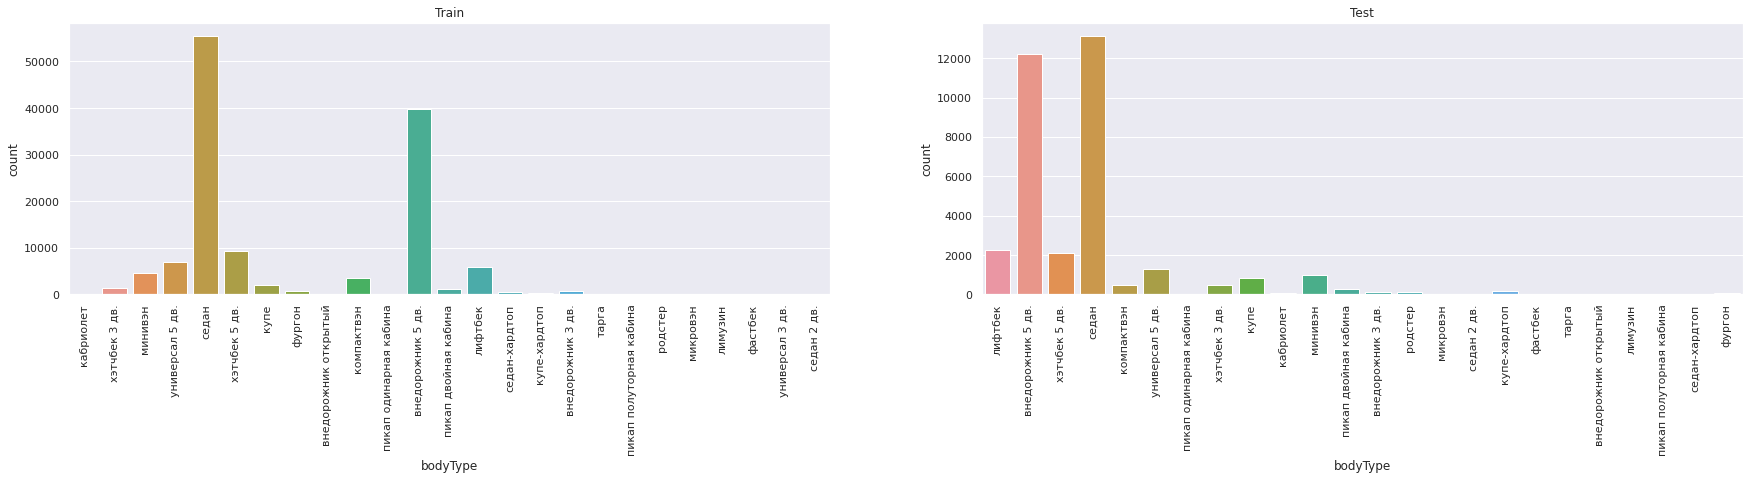

In [23]:
fig, ax = plt.subplots(1,2, figsize=(30,5))
sns.countplot(x='bodyType', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='bodyType', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак категориальный. Преобладают седаны, на втором месте - внедорожники

### brand - Марка автомобиля

Категориальный признак, перечень марок совпадает


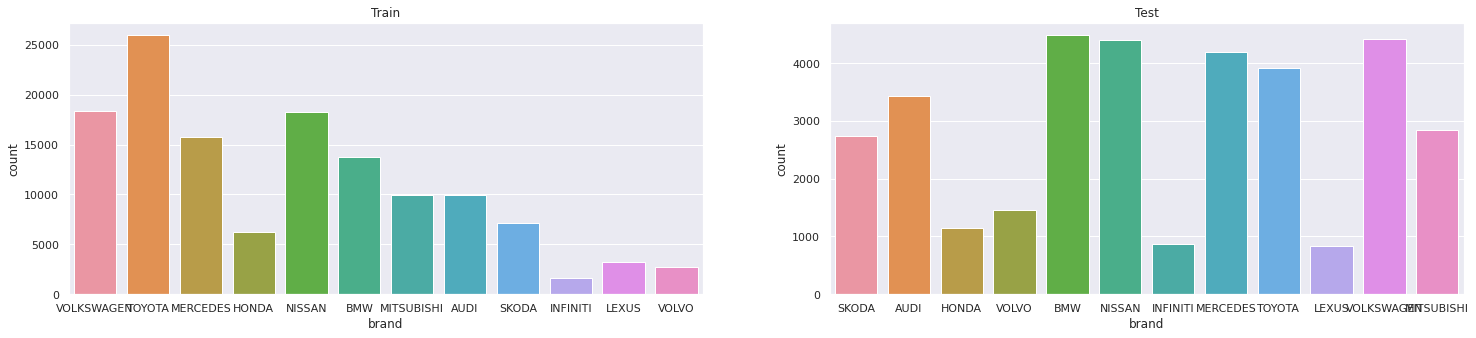

In [24]:
fig, ax = plt.subplots(1,2, figsize=(25,5))
sns.countplot(x='brand', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='brand', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Посмотрим на распределение целевой переменной по маркам авто

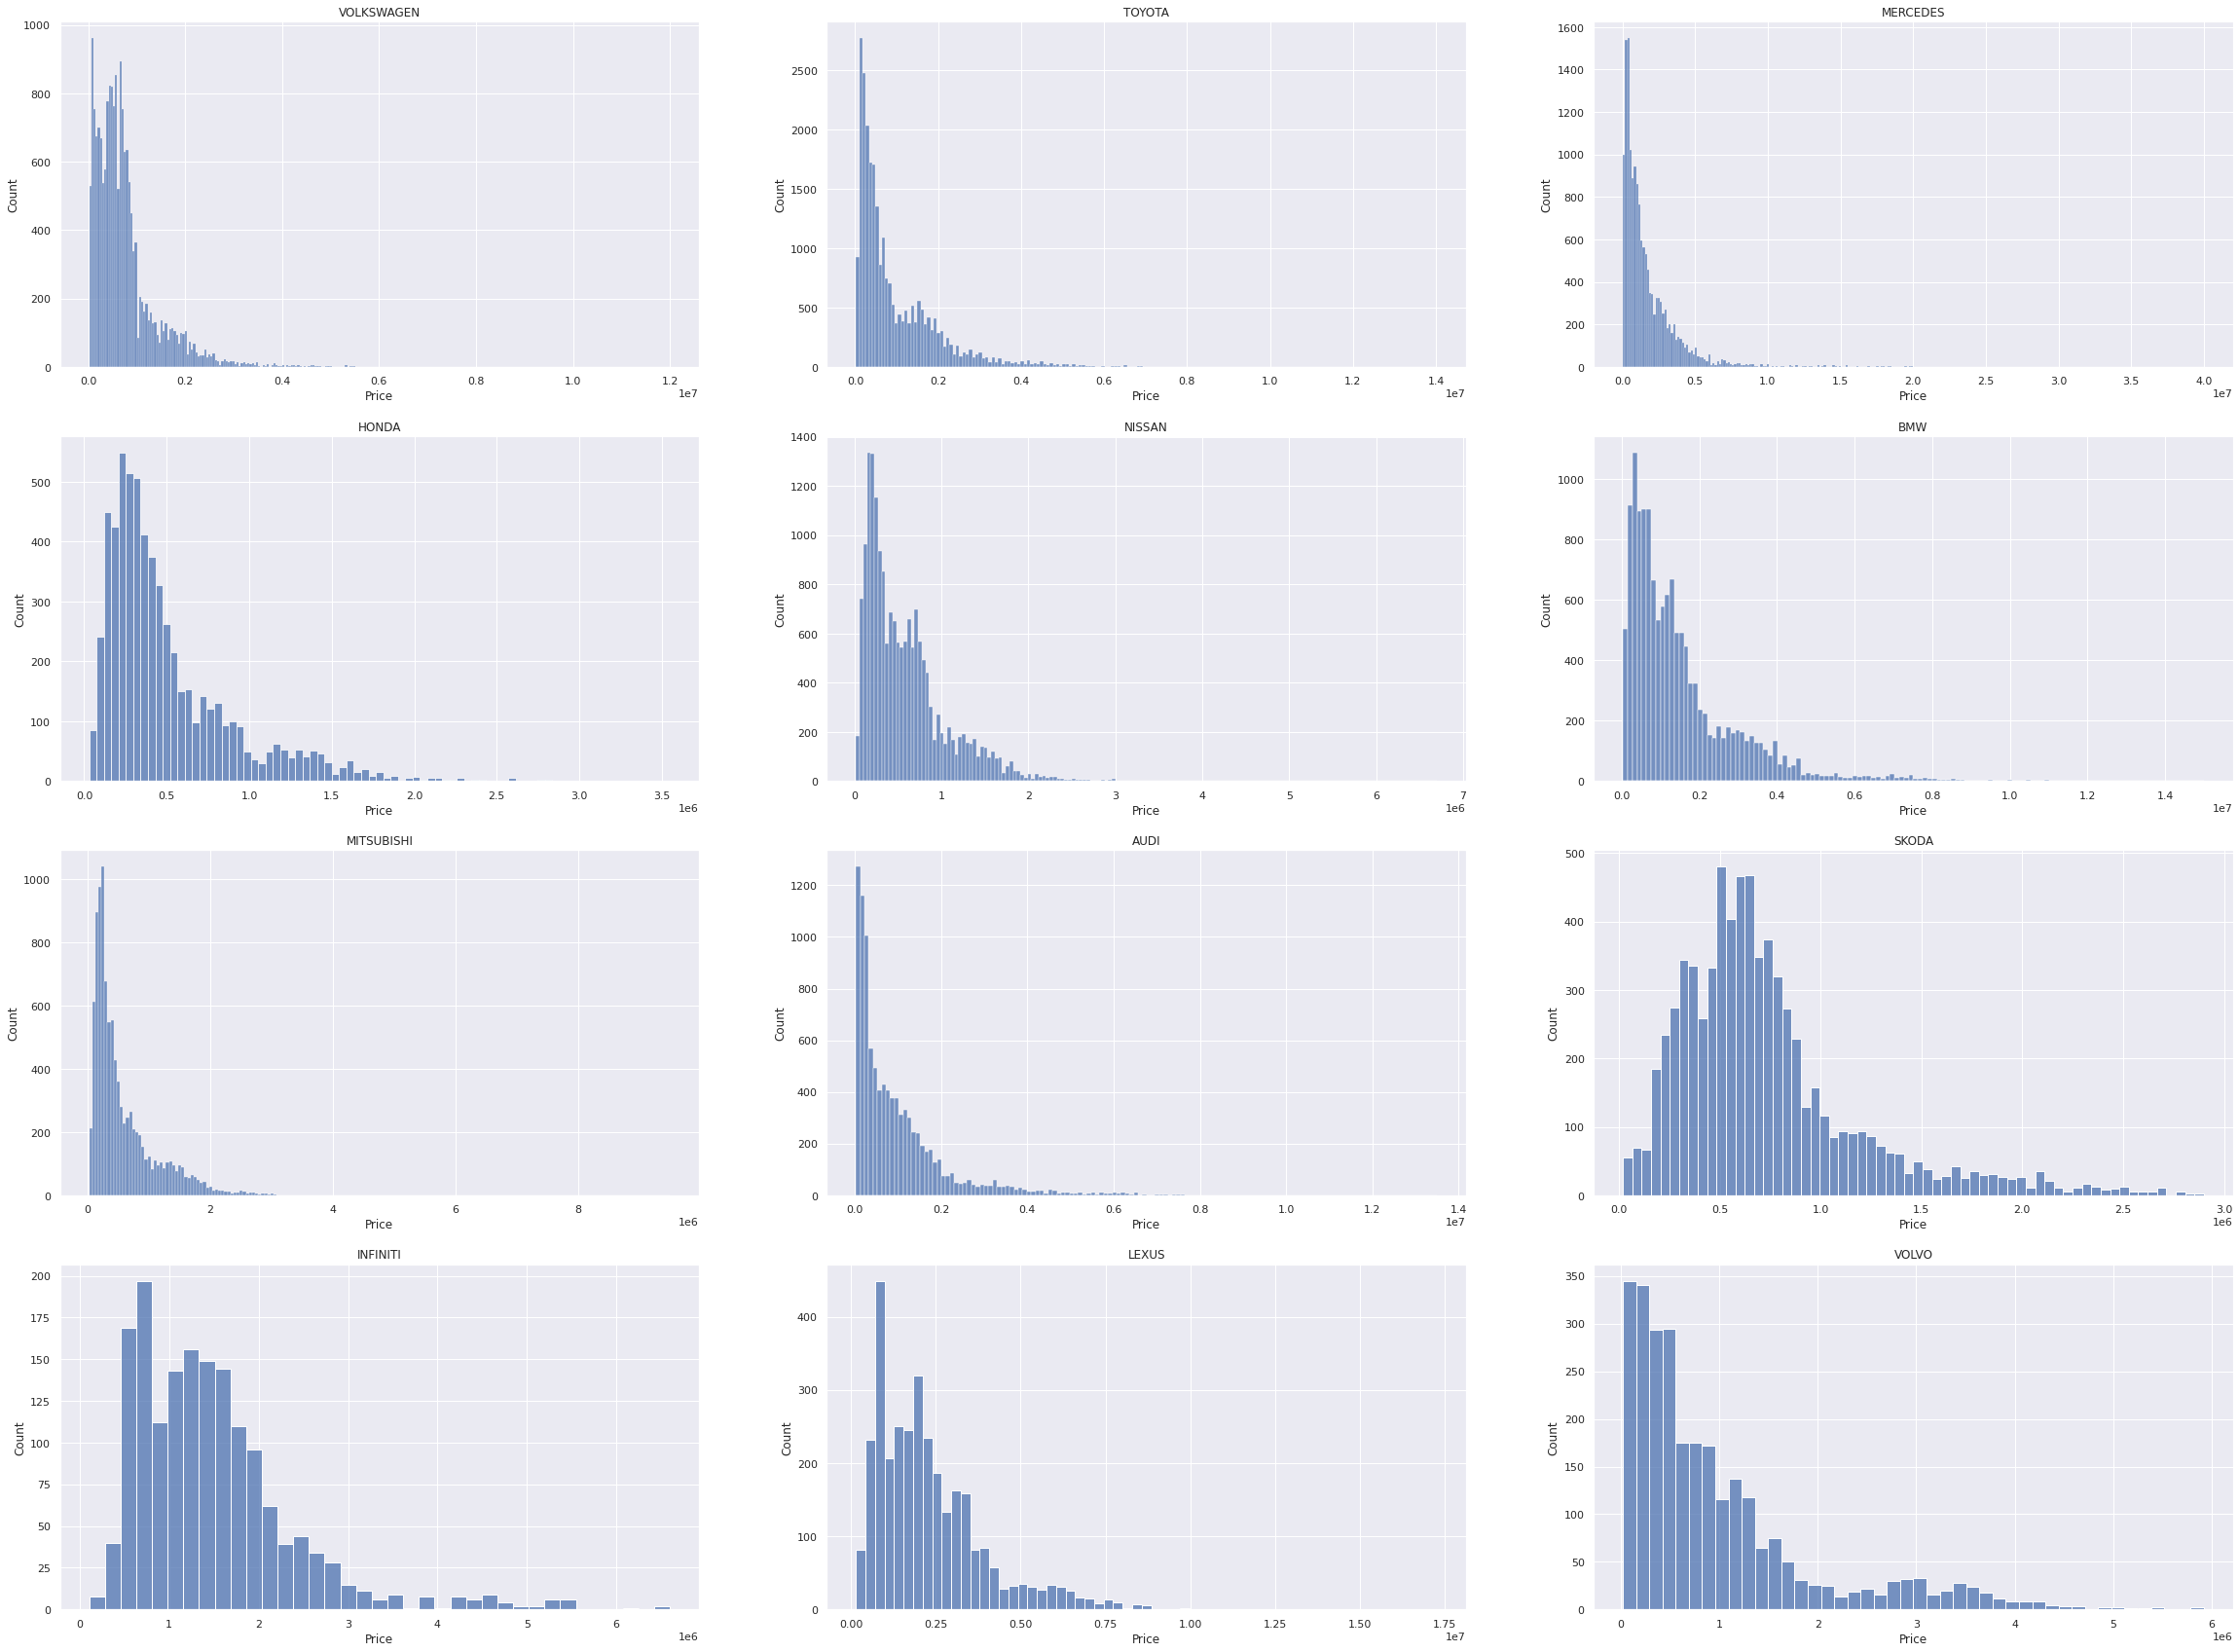

In [25]:
fig, ax = plt.subplots(4,3, figsize=(40,30))
for i in range(4):
    for j in range(3):
        sns.histplot(x=train.Price[train.brand==train.brand.unique()[i*3+j]], ax=ax[i,j])
        ax[i,j].set_title(train.brand.unique()[i*3+j])
fig.show()          



Правые хвосты предположительно связаны с наличием в выдаче б/у автомобилей новых машин с высокой ценой, которые автосалоны выставляют на продажу как б/у.
На выбросы надо посмотреть отдельно.

In [26]:
outliers = train[
    (train.Price <= train_stats[train_stats.feature_name=='Price'].iloc[0]['l_border']) |
    (train.Price >= train_stats[train_stats.feature_name=='Price'].iloc[0]['r_border'])
]

In [27]:
outliers

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,Price,model_razgon,model_consumption,model_class,segment
0,кабриолет,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/type...,бежевый,Продам очень редкий автомобиль-амфибию Volkswa...,1.1,25,['spare-wheel'],бензин,340.0,1942.0,TYPE_166,1.1 MT (25 л.с.) 4WD,0.0,1943.0,механическая,EUROPEAN,1,6 лет и 11 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,12000000,20.0,20.0,C,ECONOMY
11538,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,белый,Автoмoбиль куплeн у oфициaльногo дилера Major ...,3.0,204,"['cruise-control', 'e-adjustment-wheel', 'mult...",дизель,49990.0,2014.0,TOUAREG,3.0d AT (204 л.с.) 4WD,5.0,2014.0,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2899000,8.5,7.4,J,PREMIUM
13707,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,"Дилеры, коммерсанты и т.п. заработать на себе ...",3.6,249,"['cruise-control', 'multi-wheel', 'rear-camera...",бензин,64000.0,2014.0,TOUAREG,3.6 AT (249 л.с.) 4WD,5.0,2016.0,автоматическая,EUROPEAN,2,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2850000,8.4,10.9,J,PREMIUM
13735,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,белый,Автомобиль в идеальном состоянии. Не требует н...,3.6,249,[],бензин,62000.0,2014.0,TOUAREG,3.6 AT (249 л.с.) 4WD,5.0,2016.0,автоматическая,EUROPEAN,2,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2800000,8.4,10.9,J,PREMIUM
13803,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,Автомобиль в заводском окрасе. Полностью обслу...,3.0,204,['asr'],дизель,66256.0,2014.0,TOUAREG,3.0d AT (204 л.с.) 4WD,5.0,2016.0,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2965000,8.5,7.4,J,PREMIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132905,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101...,белый,САЛОНАМ НЕ ЗВОНИТЬ!!!|Состояние новой машины|П...,2.0,249,"['tinted-glass', 'front-centre-armrest', 'dark...",бензин,16900.0,2019.0,XC90,2.0 AT (249 л.с.) 4WD,5.0,2020.0,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4370000,7.9,7.9,J,PREMIUM
132906,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1102...,чёрный,Автомобиль продается официальным дилером Volvo...,2.0,235,"['asr', 'esp', 'lane-keeping-assist', 'airbag-...",дизель,24933.0,2019.0,XC90,2.0d AT (235 л.с.) 4WD,5.0,2020.0,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5450000,7.8,5.8,J,PREMIUM
132907,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1102...,коричневый,РОЛЬФ Алтуфьево — это целых 29 лет успешной по...,2.0,249,"['asr', 'airbag-driver', 'hsa', 'airbag-curtai...",бензин,23550.0,2019.0,XC90,2.0 AT (249 л.с.) 4WD,5.0,2020.0,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5297000,7.9,7.9,J,PREMIUM
132908,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1102...,серый,#cme135-YlaVSq_|Автомобиль находится по адресу...,2.0,249,"['cruise-control', 'electro-window-front', 'mu...",бензин,35000.0,2017.0,XC60,2.0 AT (249 л.с.) 4WD,5.0,2020.0,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3578000,6.8,7.3,J,PREMIUM


In [28]:
outliers.brand.unique()

array(['VOLKSWAGEN', 'TOYOTA', 'MERCEDES', 'HONDA', 'NISSAN', 'BMW',
       'MITSUBISHI', 'AUDI', 'SKODA', 'INFINITI', 'LEXUS', 'VOLVO'],
      dtype=object)

Посмотрим автомобили каких годов выпуска вышли по цене за 1,5 межквартильных расстояния от 1 и 3 квартилей

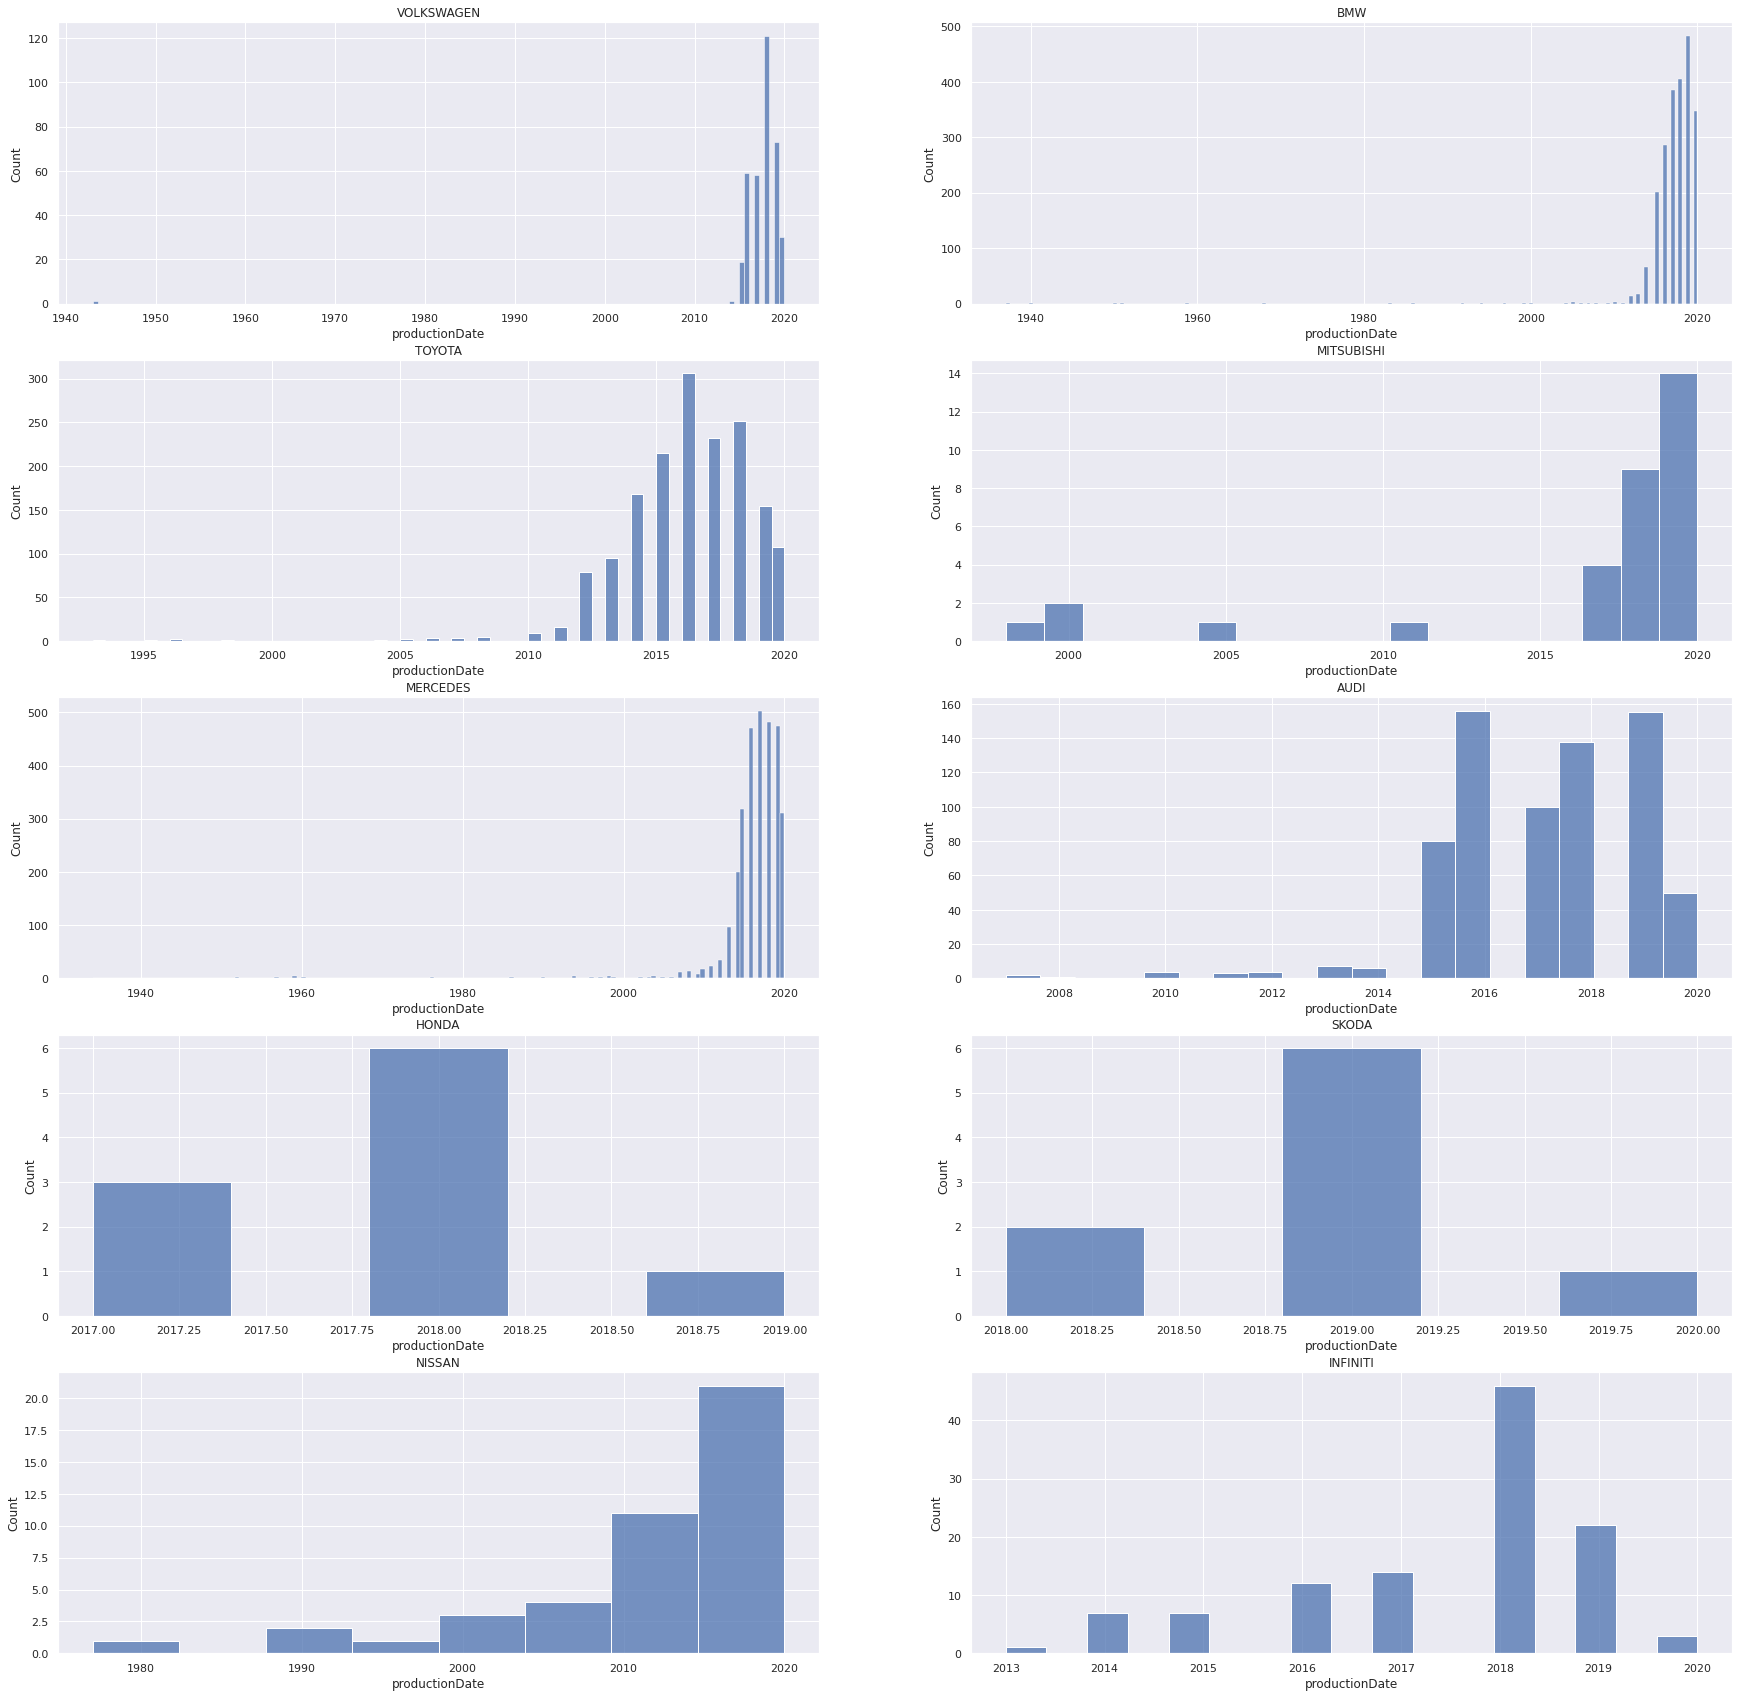

In [29]:
fig, ax = plt.subplots(5,2, figsize=(30,30))
for i in range(5):
    for j in range(2):
        sns.histplot(x = outliers.productionDate[outliers.brand==outliers.brand.unique()[i+j*5]], ax=ax[i,j])
        ax[i,j].set_title(outliers.brand.unique()[i+j*5])
fig.show()   

Проверим AUDI, MERCEDES, BMW, TOYOTA, LEXUS, NISSAN у остальных марок год выпуска для дорогих автомобилей кажется приемлемым

In [30]:
outliers[outliers['brand'].isin(['AUDI', 'MERCEDES', 'BMW', 'TOYOTA', 'LEXUS', 'NISSAN']) & (outliers.productionDate<=2010)].sample(30)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,Price,model_razgon,model_consumption,model_class,segment
111841,купе,AUDI,https://auto.ru/cars/used/sale/audi/r8/1102719...,чёрный,Продаю шикарный авто! Таких уже не делают! R8 ...,4.2,420,"['alloy-wheel-disks', '19-inch-wheels', 'esp',...",бензин,27500.0,2007.0,R8,V8 4.2 AMT (420 л.с.) 4WD,2.0,2007.0,роботизированная,EUROPEAN,3,11 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4300000,4.600000,13.500000,S,PREMIUM
50320,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/g_klas...,чёрный,Автомобиль не требует вложений. Оригинальная з...,5.0,296,"['cruise-control', 'electro-window-front', 'e-...",бензин,84000.0,2006.0,G_KLASSE,500 5.0 AT (296 л.с.) 4WD,5.0,2008.0,автоматическая,EUROPEAN,3,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,3890000,10.200000,16.700000,J,PREMIUM
50526,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/g_klas...,чёрный,Стоит обвес Amg оригинал|Выхлопная система Amg...,5.5,388,[],бензин,110000.0,2006.0,G_KLASSE,500 5.5 AT (388 л.с.) 4WD,5.0,2008.0,автоматическая,EUROPEAN,2,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3000000,6.100000,14.700000,J,PREMIUM
86949,купе,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101962...,серый,"BMW, e36, купэ на В8|Корч! Пушка! Гонка! 🚀 Рак...",1.8,140,[],бензин,100000.0,1990.0,3ER,318i 1.8 MT (140 л.с.),2.0,1992.0,механическая,EUROPEAN,2,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,7000000,10.200000,8.066667,D,PREMIUM
46730,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/g_klas...,чёрный,"Неcтapеющaя клaссика ""4х4 в квадpатe"" - будет ...",3.0,113,"['engine-proof', '18-inch-wheels']",дизель,10000.0,1990.0,G_KLASSE,300 3.0d MT (113 л.с.) 4WD,5.0,1990.0,механическая,EUROPEAN,3,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,4350000,22.200000,12.200000,J,PREMIUM
45075,родстер,MERCEDES,https://auto.ru/cars/used/sale/mercedes/sl_kla...,синий,Продаю машину легенду – знаменитый SL в 107 ку...,3.8,204,[],бензин,100000.0,1971.0,SL_KLASSE,380 3.8 AT (204 л.с.),2.0,1984.0,автоматическая,EUROPEAN,1,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен,3150000,9.800000,8.517967,S,PREMIUM
44357,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/w111/1...,бежевый,Mercedes-Benz W111 220 SEb cabriolet.|Один из ...,2.2,120,[],бензин,56000.0,1959.0,W111,220 SE 2.2 MT (120 л.с.),2.0,1963.0,механическая,EUROPEAN,3,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,6800000,12.800000,7.125487,F,MEDIUM
68517,купе,NISSAN,https://auto.ru/cars/used/sale/nissan/skyline/...,серый,"Прошу салоны, перекупщиков и всех других дельц...",2.6,280,[],бензин,15000.0,1989.0,SKYLINE,GT-R 2.6 MT (280 л.с.) 4WD,2.0,1993.0,механическая,JAPANESE,1,NaN,Оригинал,полный,Правый,Не требует ремонта,Растаможен,3000000,5.800000,14.200000,D,MEDIUM
51844,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/g_klas...,чёрный,ПРОДAЮ ЛЮБИMЦA . НE CПЕШУ . НА OБМЕH 2750.000p...,5.0,296,"['asr', 'esp', 'airbag-passenger', 'knee-airba...",бензин,196000.0,2006.0,G_KLASSE,500 5.0 AT (296 л.с.) 4WD,5.0,2008.0,автоматическая,EUROPEAN,3,12 лет и 11 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2950000,10.200000,16.700000,J,PREMIUM
32618,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/land_cru...,серебристый,Maшинa в идeaльном cостоянии !!! Заменa маcла...,4.5,235,[],дизель,110000.0,2007.0,LAND_CRUISER,4.5d AT (235 л.с.) 4WD,5.0,2010.0,автоматическая,JAPANESE,2,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3000000,9.500000,10.200000,J,PREMIUM


Ну вроде все в порядке - в основном эксклюзивные машины, есть несколько завышенных цен, но удалять их руками не будем.

### car_url - Ссылка на страницу объявления. Убираем.

### color - цвет автомобиля

In [31]:
sorted(test.color.unique())

['бежевый',
 'белый',
 'голубой',
 'жёлтый',
 'зелёный',
 'золотистый',
 'коричневый',
 'красный',
 'оранжевый',
 'пурпурный',
 'розовый',
 'серебристый',
 'серый',
 'синий',
 'фиолетовый',
 'чёрный']

In [32]:
sorted(train.color.unique())

['бежевый',
 'белый',
 'голубой',
 'жёлтый',
 'зелёный',
 'золотистый',
 'коричневый',
 'красный',
 'оранжевый',
 'пурпурный',
 'розовый',
 'серебристый',
 'серый',
 'синий',
 'фиолетовый',
 'чёрный']

Категориальный признак. Список цветов идентичен в train и test

<AxesSubplot:xlabel='color', ylabel='count'>

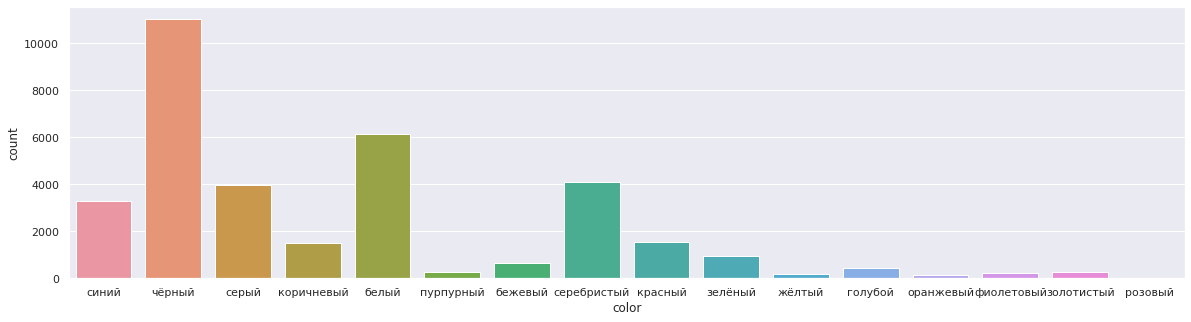

In [33]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x='color', ax=ax, data=test)

### complectation_dict в test
Выглядит как комплектация модели автомобиля. В признаке слишком много пропусков. Убираем

### description - Текстовые комментарии к объявлению
Может быть полезен, но надо применять анализ текста. Например для выявления типа продавца - частное лицо или автосалон

### engineDisplacement - Объем двигателя

In [34]:
sorted(train.engineDisplacement.unique())

[0.0,
 0.6,
 0.7,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9,
 3.0,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 3.6,
 3.7,
 3.8,
 3.9,
 4.0,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6,
 4.7,
 4.8,
 4.9,
 5.0,
 5.2,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6.0,
 6.2,
 6.3,
 6.6,
 6.8]

Признак по происхождению числовой. Похож на категориальный, но будем обрабатывать его как числовой.

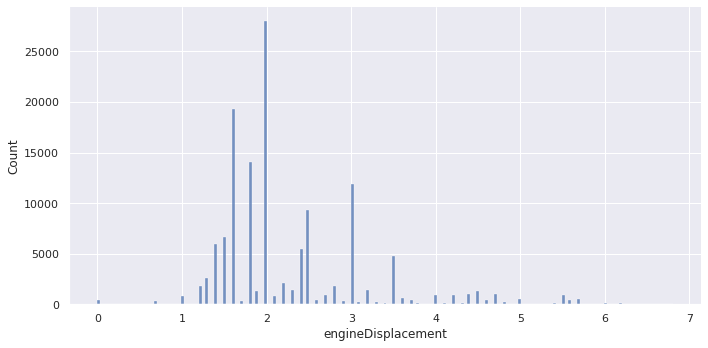

In [35]:
sns.displot(x=train.engineDisplacement, kde=False, rug=False, height=5, aspect=2)

Видны популярные размеры двигателей 1.5, 2.0, 3.0

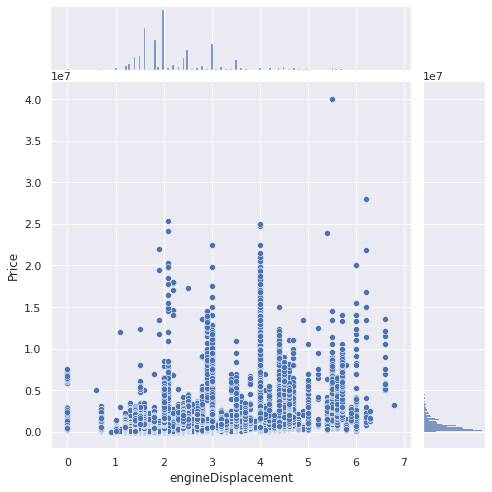

In [36]:
sns.jointplot(x='engineDisplacement', y='Price', data=train, kind='scatter', height=7)

### enginePower - Мощность двигателя

Признак числовой. Распределение смещено. Что объяснимо наибольшей популярностью авто с мощностью от 100 до 200

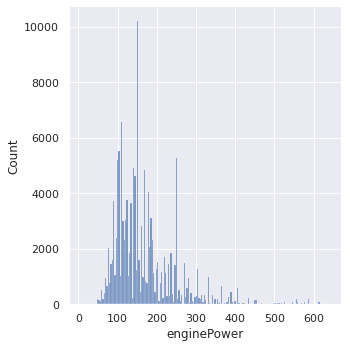

In [37]:
sns.displot(x=train.enginePower, kde=False, rug=False)

Преобладают авто с мощностью от 100 до 200 л.с. И виден "налоговый" пик в 249 л.с., после которого резко повышается ставка налога на автомобиль. Автопроизводители искусствено ограничивают мощность двигателей на этом уровне.
Посмотрим на взаимосвязь цены и мощности.

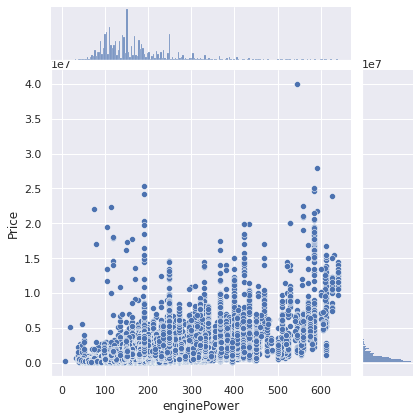

In [38]:
sns.jointplot(x='enginePower', y='Price', data=train, kind='scatter')

Ожидал увидеть более линейную зависимость. 

### equipment_dict - Словарь с оборудованием автомобиля
В test выглядит как словарь, в train уже обработан в виде списка оборудования. Будем словарь преобразовывать в список, а из списка делать dummy-переменные

### fuelType - Тип топлива

In [39]:
sorted(train.fuelType.unique())

['бензин', 'газ', 'гибрид', 'дизель', 'электро']

In [40]:
sorted(test.fuelType.unique())

['бензин', 'газ', 'гибрид', 'дизель', 'электро']

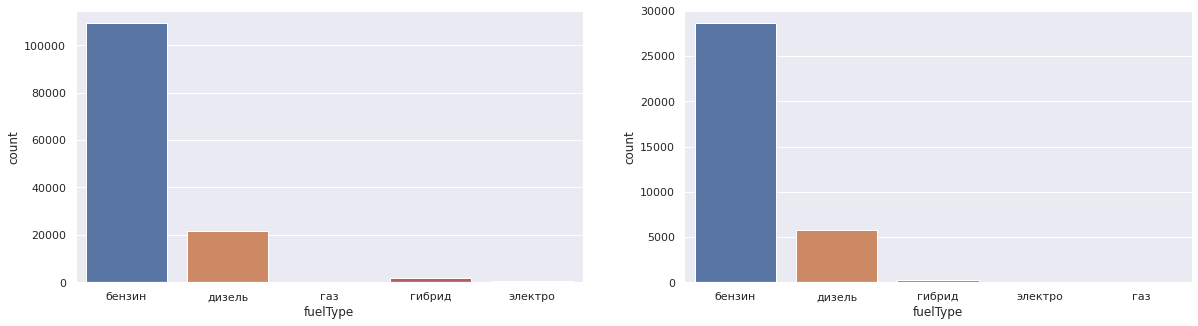

In [41]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='fuelType', data=train, ax=ax[0])
sns.countplot(x='fuelType', data=test, ax=ax[1])
fig.show()


Признак категориальный. Соотношение автомобилей по типу топлива одинаковое

### mileage - пробег

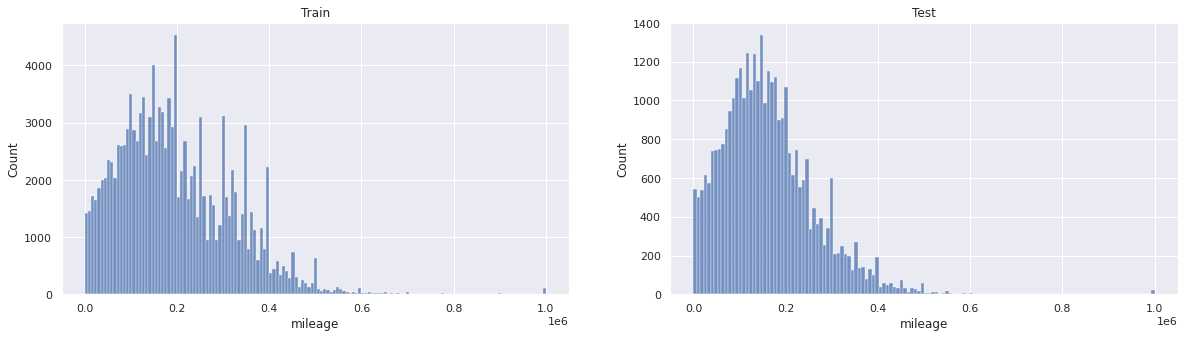

In [42]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(x='mileage', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.histplot(x='mileage', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Числовой признак. Распределение смещено. Преобладают авто с пробегом от 80 до 150 тыс. км.

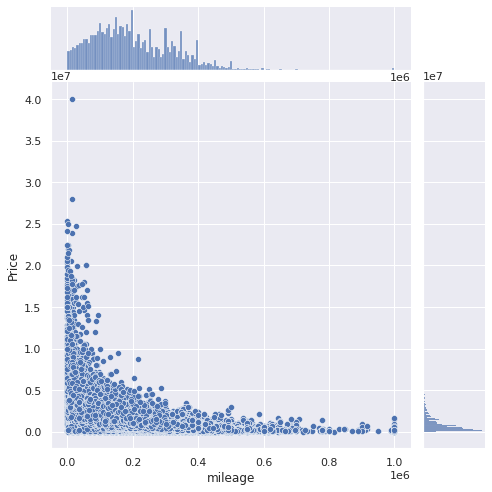

In [43]:
sns.jointplot(x='mileage', y='Price', data=train, kind='scatter', height=7)

Ну для этого признака взаимосвязь пробега и цены более наглядна, чем для мощности. Зависимость похожа на 1/x.

### modelDate - Дата выхода модели в продажу

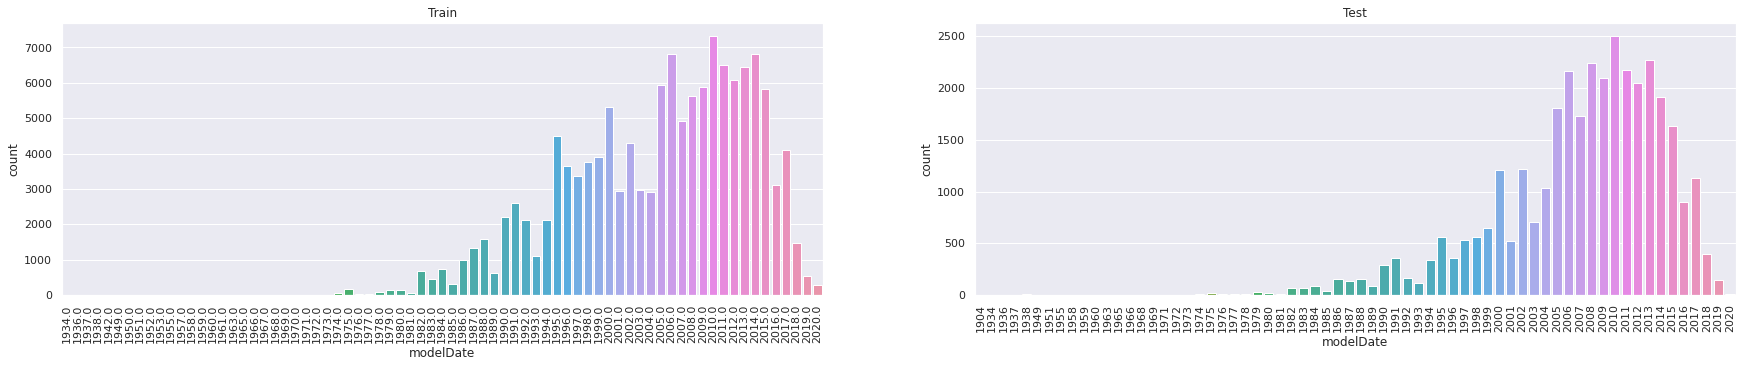

In [44]:
fig, ax = plt.subplots(1,2, figsize=(30,5))
sns.countplot(x='modelDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='modelDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак больше категориальный, чем числовой. Распределения одинаковы в train и test
Посмотрим на связь с ценой

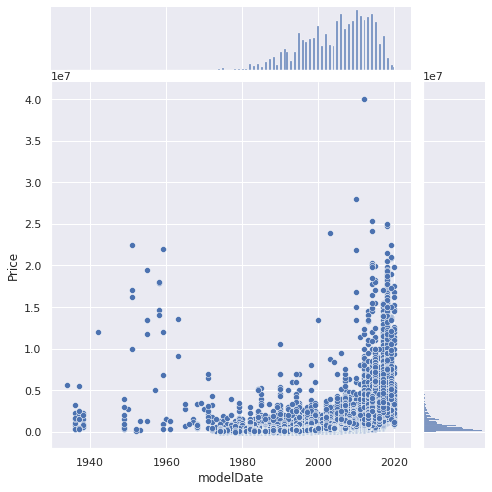

In [45]:
sns.jointplot(x='modelDate', y='Price', data=train, kind='scatter', height=7)

Тут все более-менее закономерно, чем позднее модель, тем она и дороже. Также присутствуют коллекционные дорогие авто древних годов выпуска.

### model_info

test.model_info - выглядит как некий справочник по моделям, в train выгрузке отсутствует. Убираем

### model_name

Просто название автомобиля. Категориальный. 544 уникальных в test, 657 в train. Будем сокращать, используя 90% самых популярных названий.

In [46]:
print(len(test.model_name.unique()))
print(len(train.model_name.unique()))

544
657


### name

Новой информации не несет, является совокупностью значений признаков модели авто, трансмиссии, мощности двигателя и привода. Убираем

### numberOfDoors - количество дверей

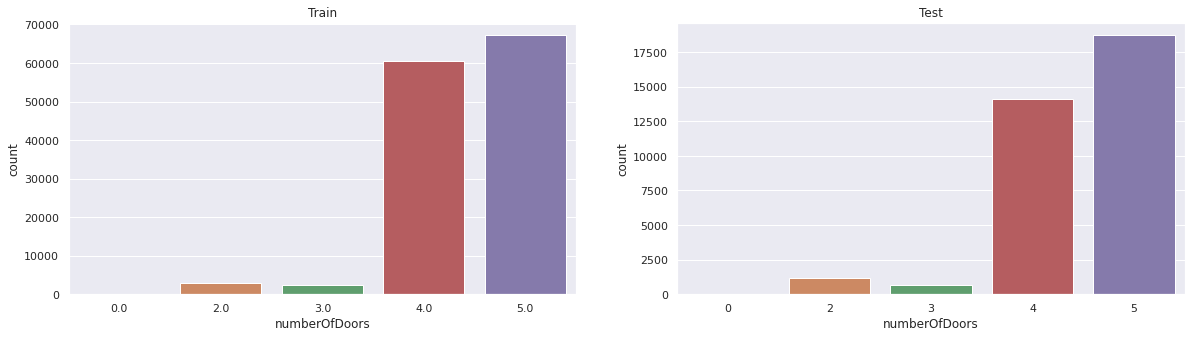

In [47]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='numberOfDoors', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='numberOfDoors', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Распределение признаков в train и test совпадает

### parsing_unixtime

Время парсинга датасета в формате unixtime. Убираем

### priceCurrency

Валюта объявления. Все объявления в рублях. Убираем

### productionDate - Дата производства автомобиля

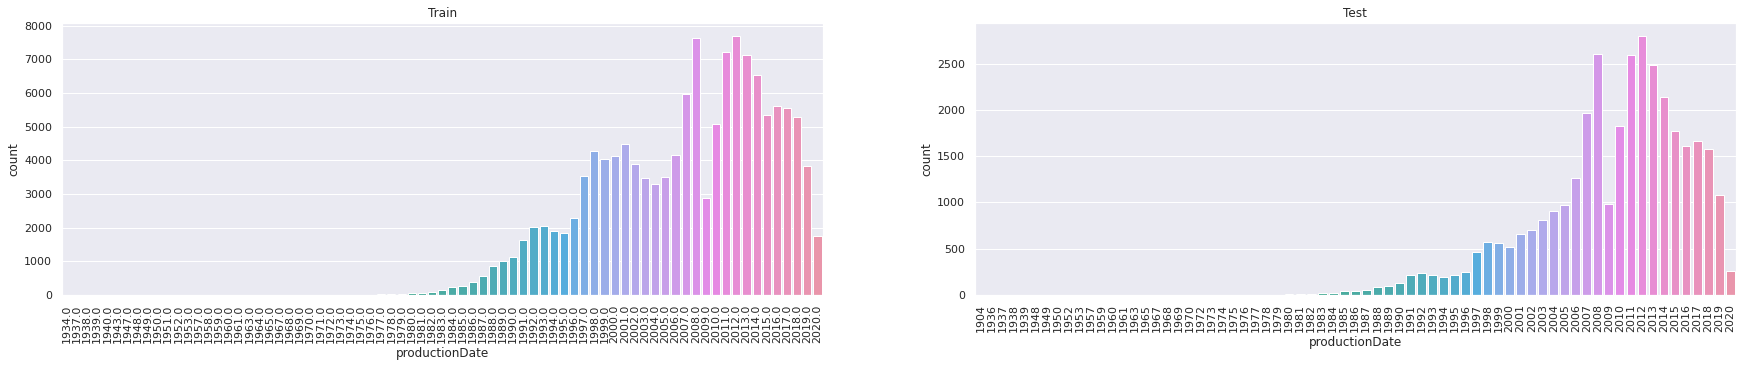

In [48]:
fig, ax = plt.subplots(1,2, figsize=(30,5))

sns.countplot(x='productionDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='productionDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак больше категориальный, чем числовой. Распределения в test и train похожи. Заметен значимый провал кризисного 2009 года.

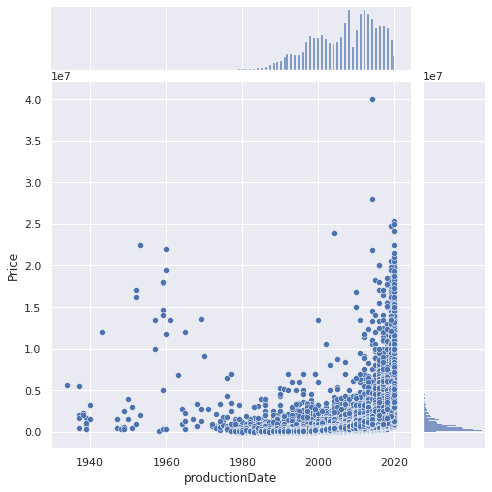

In [49]:
sns.jointplot(x='productionDate', y='Price', data=train, kind='scatter', height=7)

Взаимосвязь цены и года выпуска авто логичная. Выбросы уже проанализированы.

### sell_id

Какой-то идентификатор объявления. Информации не несет. Убираем

### super_gen

test.super_gen[0]

> '{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

очередной справочник с привязкой к id. Можно было бы извлекать информацию, но пропусков в датасете вроде и нет. Убираем.

### vehicleConfiguration

test.vehicleConfiguration[2]
> 'LIFTBACK ROBOT 1.8'

Признак дублирует имеющуюся информацию. Убираем.

### vehicleTransmission - привод автомобиля

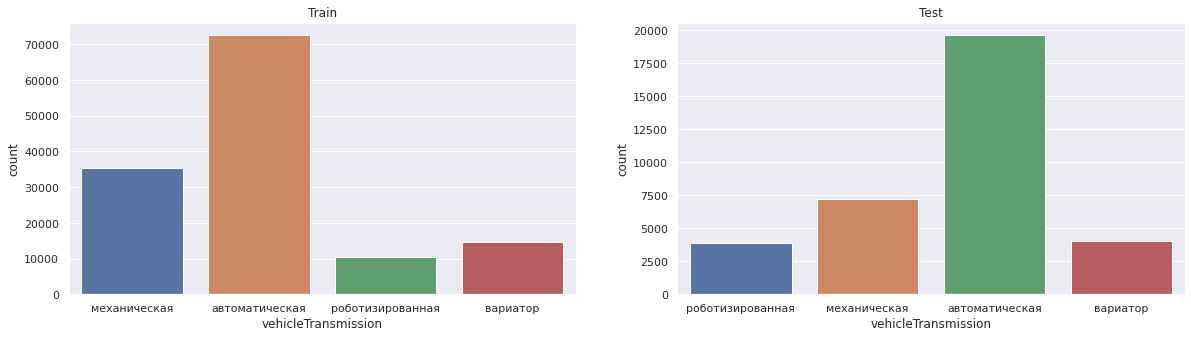

In [50]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='vehicleTransmission', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='vehicleTransmission', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Распределение признака в train и test совпадает

vendor

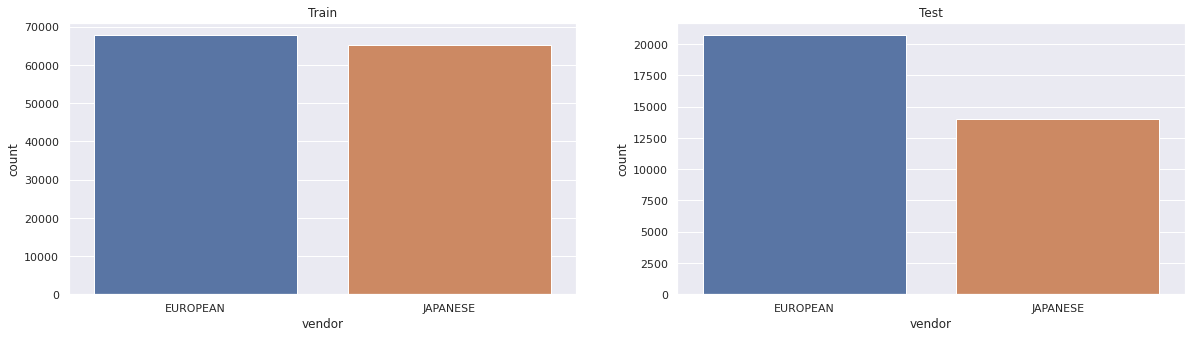

In [51]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='vendor', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='vendor', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Бинарный признак. В test японских автомобилей меньше, чем европейских

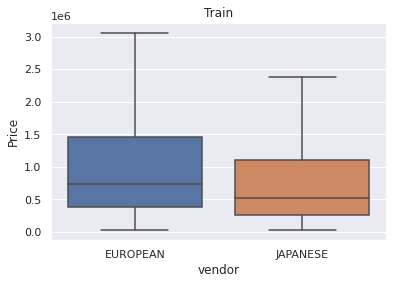

In [52]:
sns.boxplot(x='vendor', y='Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Европейские автомобили дороже

### Владельцы

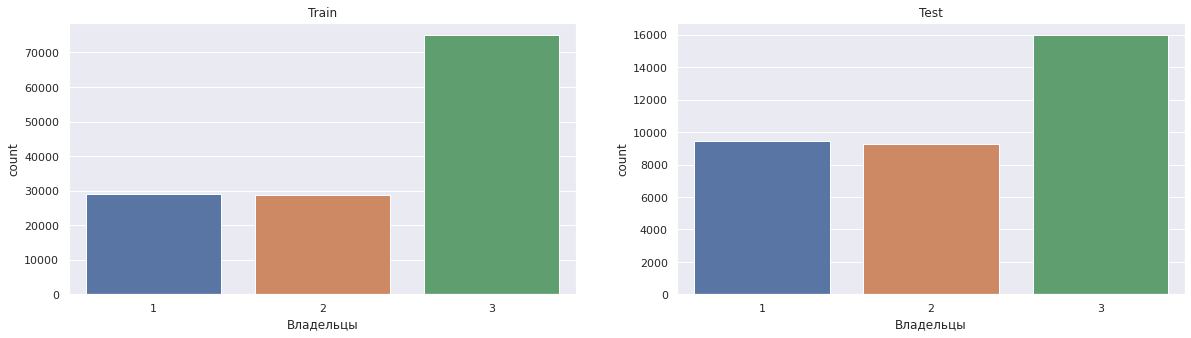

In [53]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='Владельцы', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Владельцы', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Картина по датасетам приблизительно одинаковая

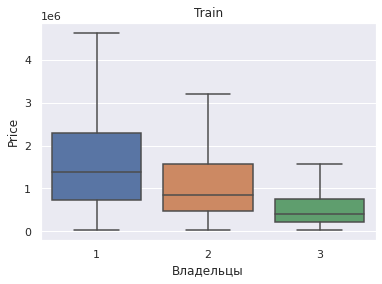

In [54]:
sns.boxplot(x='Владельцы', y='Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Влияние на цену количества владельцев - явно выражено

### Владение

Слишком много пропусков. Убираем.

### ПТС

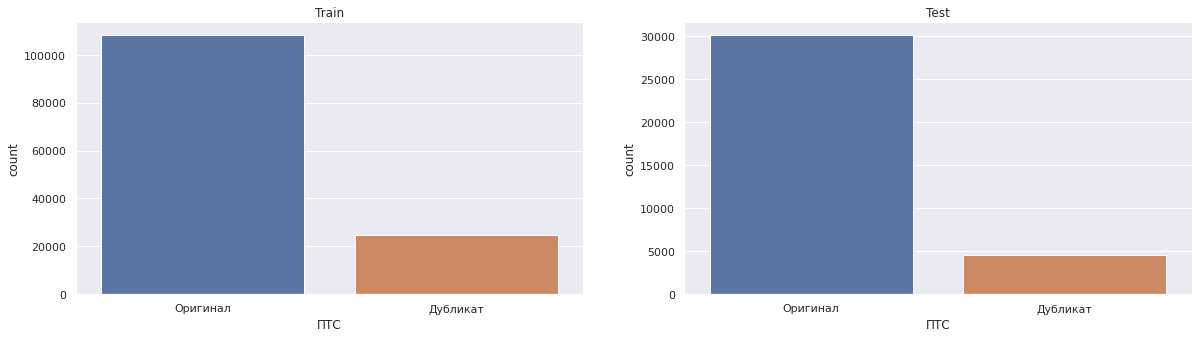

In [55]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='ПТС', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='ПТС', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Бинарный признак. В обоих датасетах преобладает большинство авто с оригиналом ПТС

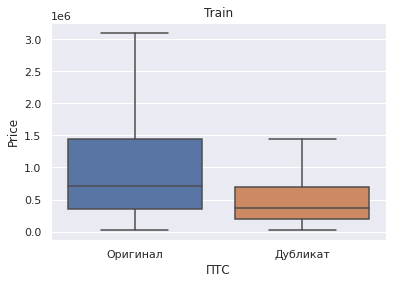

In [56]:
sns.boxplot(x='ПТС', y='Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Машины с дубликатами ПТС сильно дешевле. Но скорее всего и старше по возрасту.

### Привод

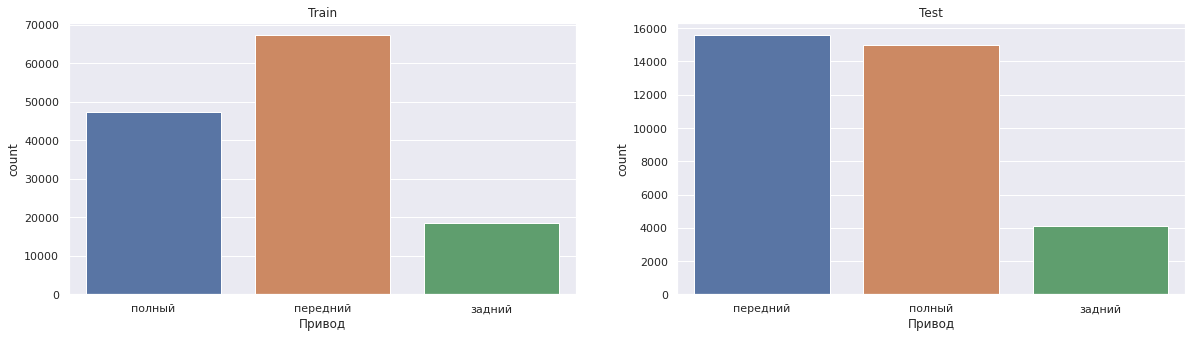

In [57]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='Привод', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Привод', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Признак категориальный. В train преобладают переднеприводные авто. В test переднеприводных и полноприводных приблизительно одинаковое количество. Заднеприводные авто в меньшинстве.

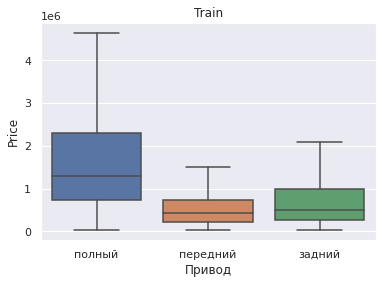

In [58]:
sns.boxplot(x='Привод', y='Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Полноприводные машины дороже. Переднеприводные - дешевый и массовый сегмент.

### Руль

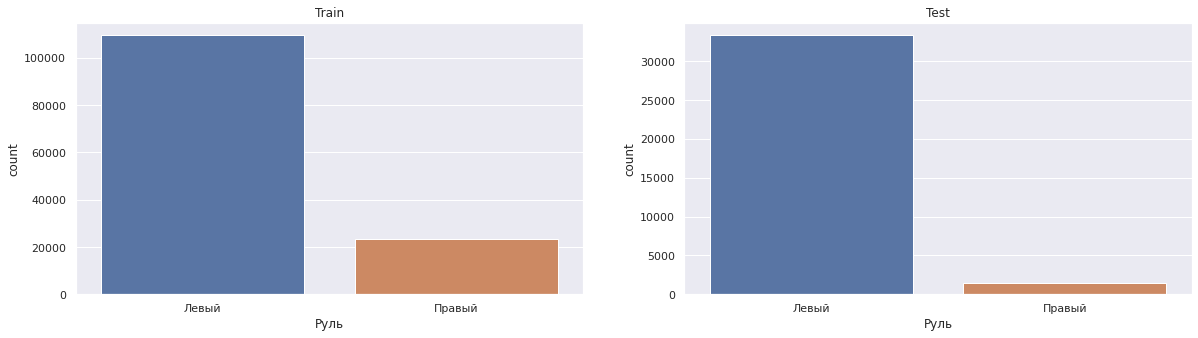

In [59]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='Руль', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Руль', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Признак бинарный. Картина по датасетам одинаковая.

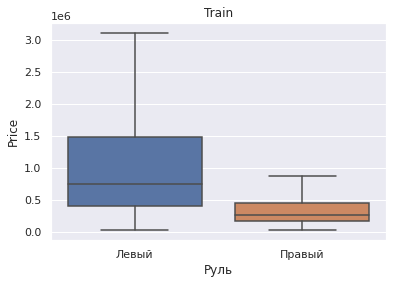

In [60]:
sns.boxplot(x='Руль', y='Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

На стоимость влияние оказывает

### Состояние

Весь признак имеет одинаковое значение 'Не требует ремонта'
Убираем

### Таможня

Весь признак имеет одинаковое значение 'Растаможен'.
Убираем.

## Новые признаки, полученные после обновления парсера и повторной выгрузки

### model_razgon

Text(0.5, 1.0, 'Train')

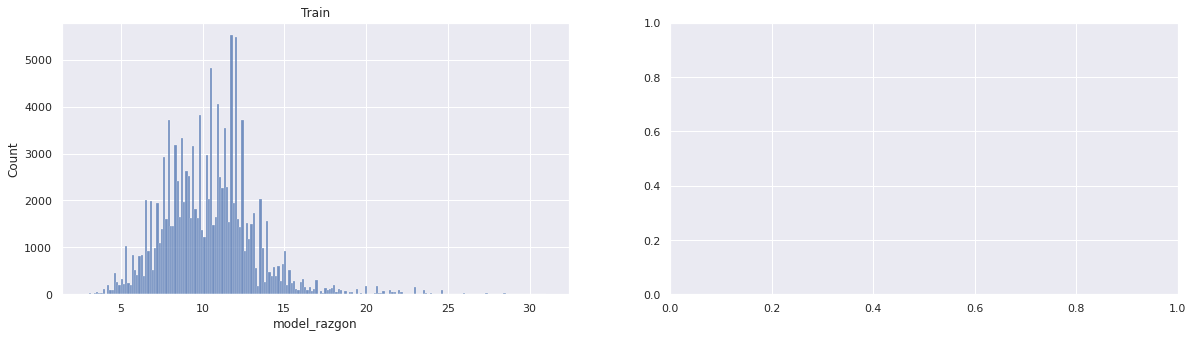

In [61]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(x='model_razgon', data=train, ax=ax[0])
ax[0].set_title('Train')
#sns.histplot(x='model_razgon', data=test, ax=ax[1])
#ax[1].set_title('Test')
#fig.show()

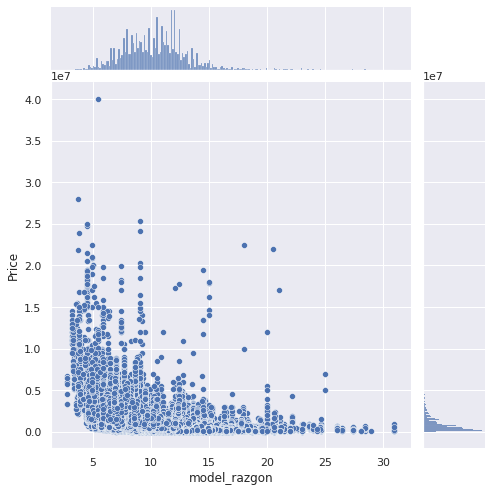

In [62]:
sns.jointplot(x='model_razgon', y='Price', data=train, kind='scatter', height=7)

Числовой признак, показывающий время в секундах, необходимое автомобилю для разгона до 100 км/ч. Признак распределен нормально. Есть хвост медленно разгоняющихся авто. Видно, что чем быстрее разгоняется авто, тем оно дороже. Данные в  test будем заполнять исходя из данных train. Хотя в test и были признаки, содержащие похожую информацию.

### model_consumption

Text(0.5, 1.0, 'Train')

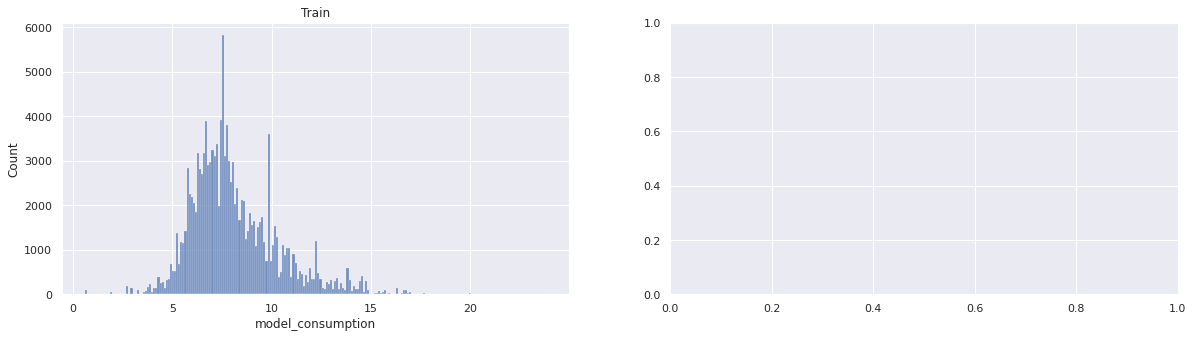

In [63]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(x='model_consumption', data=train, ax=ax[0])
ax[0].set_title('Train')
#sns.histplot(x='model_razgon', data=test, ax=ax[1])
#ax[1].set_title('Test')
#fig.show()

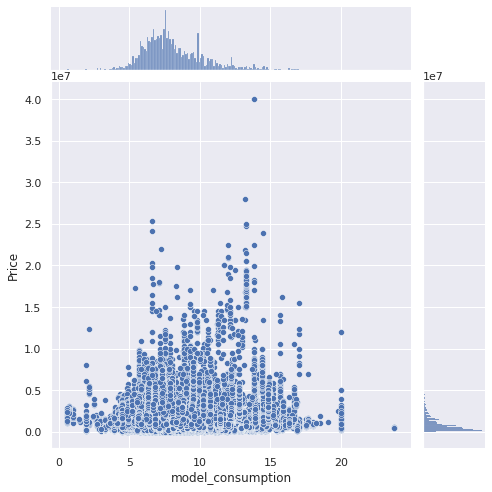

In [64]:
sns.jointplot(x='model_consumption', y='Price', data=train, kind='scatter', height=7)

Числовой признак, показывающий расход топлива в л на 100 км. Признак распределен нормально. Явной связи с ценой нет. Данные в  test будем заполнять исходя из данных train. Хотя в test и были признаки, содержащие похожую информацию. Если будет перелимит по памяти, кандидат на удаление.

### model_class

Text(0.5, 1.0, 'Train')

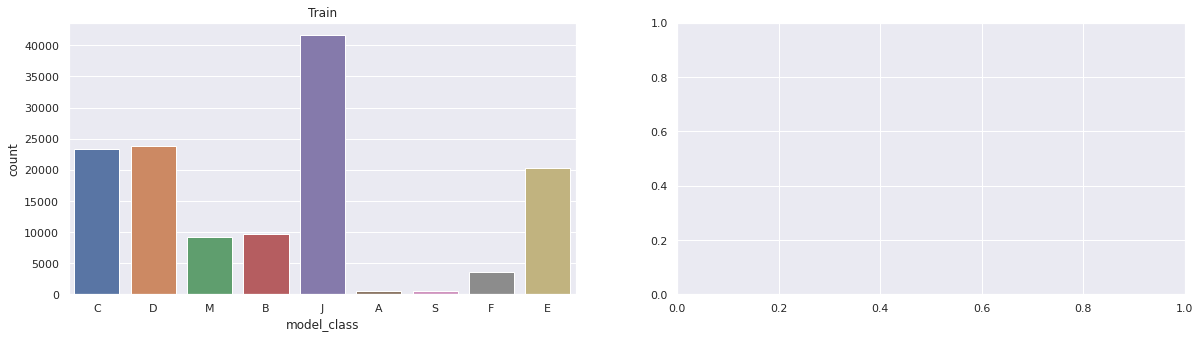

In [65]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot (x='model_class', data=train, ax=ax[0])
ax[0].set_title('Train')
#sns.histplot(x='model_razgon', data=test, ax=ax[1])
#ax[1].set_title('Test')
#fig.show()

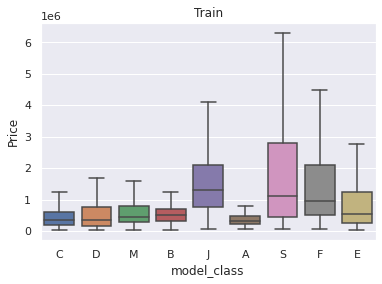

In [66]:
sns.boxplot(x='model_class', y='Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Категориальный признак. В train явно преобладают авто с классом J (это внедорожники и кроссоверы). Боксплот показывает, что класс оказывает влияние на цену автомобиля. Test заполним по данным train.

### segment

Text(0.5, 1.0, 'Train')

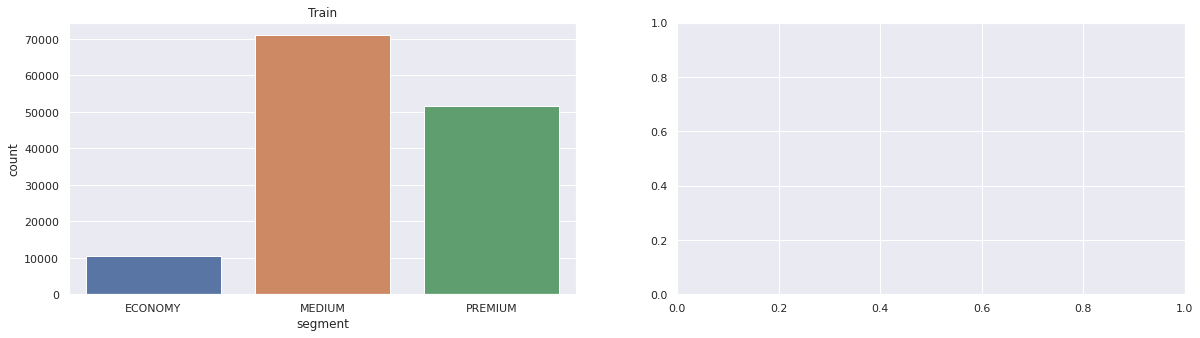

In [67]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot (x='segment', data=train, ax=ax[0])
ax[0].set_title('Train')
#sns.histplot(x='model_razgon', data=test, ax=ax[1])
#ax[1].set_title('Test')
#fig.show()

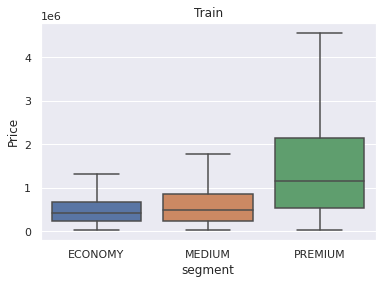

In [68]:
sns.boxplot(x='segment', y='Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Категориальный признак. Обозначает принадлежность авто к ценовому сегменту: эконом, медиум или премиум. На цену влияние имеет. Используем. Отсутствующие в test данные заполним по train.

## Data Preprocessing

### Preprocessing

In [69]:
# Конвертируем текстовый признак c опциями в список 
train.equipment_dict = train.equipment_dict.apply(lambda x: clear_text_list(x))

In [70]:
# Объединим датасеты, предварительно пометив train и test
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['Price'] = 0 # в тесте у нас нет значения Price, заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [71]:
# Разделим features по типу

num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'model_razgon', 'model_consumption' ]
    
bin_cols = ['vendor', 'ПТС', 'Руль']
       
cat_cols = ['bodyType', 'brand','color', 'fuelType', 'model_name', 'numberOfDoors',
            'vehicleTransmission', 'Владельцы',  'Привод', 'model_class', 'segment']

len(num_cols)+len(bin_cols)+len(cat_cols)

21

Посмотрим на корреляцию числовых признаков

<AxesSubplot:>

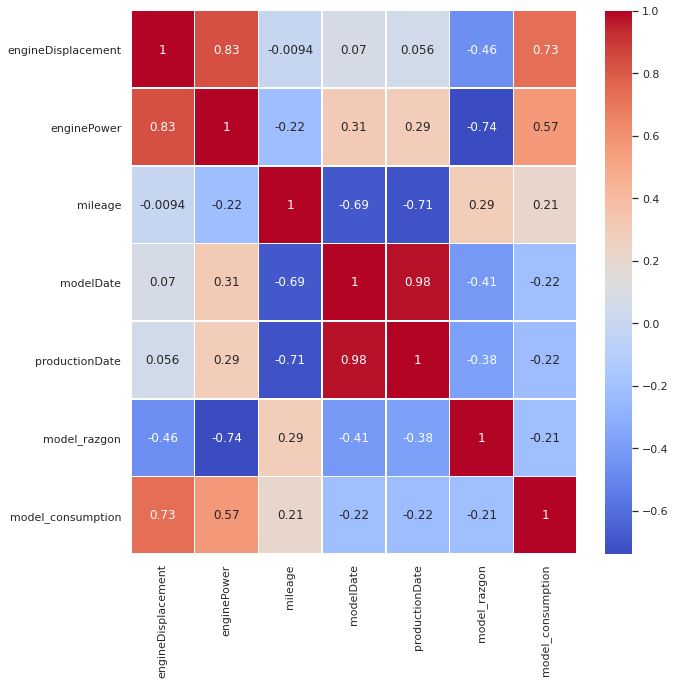

In [72]:
correlation = data[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

Ясно, что год выхода на рынок модели очень сильно коррелирует с годом выпуска авто. Также очевидна обратная корреляция между пробегом и годом выпуска и прямая корреляция объема и мощности двигателя

In [73]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### Предобработка ############################################################## 
    # убираем ненужные для модели признаки
    df_output.drop(['car_url', 'name', 'Владение', 'Состояние', 'Таможня'], axis=1, inplace=True,)
    
    # переведем объем двигателя в мл
    df_output['engineDisplacement'] = df_output['engineDisplacement']*1000
    
    # ################### Feature Engineering ####################################################
    
    # Генерируем числовые признаки - статистики по пробегу в зависимости от модели, даты производства, марки, мощности и пр.
    df_output = mileage_features('model_name', 'productionDate', df_output)
    #df_output = mileage_features('brand', 'productionDate', df_output)
    #df_output = mileage_features('enginePower', 'productionDate', df_output)
    #df_output = mileage_features('numberOfDoors', 'productionDate', df_output)
    #df_output = mileage_features('Руль', 'productionDate', df_output)
    
    # Сокращаем количество типов кузова
    df_output.bodyType = df_output.bodyType.apply(lambda x: x.split()[0])
    
    # Заполним отсутствующий в записях из test класс авто значениями исходя из марки и модели автомобиля
    df_class = pd.DataFrame(df_output.groupby(by=['brand', 'model_name'])['model_class'].agg(lambda x: x.mode())).reset_index()
    df_class.columns = ['brand', 'model_name', 'mode_class']
    df_output = df_output.merge(df_class, on=['brand', 'model_name'], how='left')
    df_output.loc[df_output.model_class.isna(), 'model_class'] = df_output[df_output.model_class.isna()].mode_class
    df_output.drop(['mode_class'], axis=1, inplace=True)
    df_output.model_class=df_output.model_class.str.strip()
    df_output.model_class.fillna('C', inplace=True)
        
    # Заполним отсутствующий в записях из test сегмент значениями исходя из марки и модели автомобиля
    df_segment = pd.DataFrame(df_output.groupby(by=['brand', 'model_name'])['segment'].agg(lambda x: x.mode())).reset_index()
    df_segment.columns = ['brand', 'model_name', 'mode_segment']
    df_output = df_output.merge(df_segment, on=['brand', 'model_name'], how='left')
    df_output.loc[df_output.segment.isna(), 'segment'] = df_output[df_output.segment.isna()].mode_segment
    df_output.drop(['mode_segment'], axis=1, inplace=True)
    df_output.segment=df_output.segment.str.strip()
    df_output.segment.fillna('ECONOMY', inplace=True)
    
    # Заполним отсутствующий в записях из test разгон значениями исходя из марки, модели автомобиля и мощности двигателя
    avg_razgon = pd.DataFrame(df_output.groupby(by=['brand', 'model_name', 'enginePower']).mean()['model_razgon']).reset_index()
    avg_razgon.columns = ['brand', 'model_name', 'enginePower','avg_razgon']
    df_output = df_output.merge(avg_razgon, on=['brand', 'model_name', 'enginePower'], how='left')
    df_output.loc[df_output.model_razgon.isna(), 'model_razgon'] = df_output[df_output.model_razgon.isna()].avg_razgon
    df_output.drop(['avg_razgon'], axis=1, inplace=True)
        
    # Заполним оставшиеся пропуски разгона средним значением для мощности двигателя
    avg_razgon = pd.DataFrame(df_output.groupby(by=['enginePower']).mean()['model_razgon']).reset_index()
    avg_razgon.columns = ['enginePower','avg_razgon']
    df_output = df_output.merge(avg_razgon, on=['enginePower'], how='left')
    df_output.loc[df_output.model_razgon.isna(), 'model_razgon'] = df_output[df_output.model_razgon.isna()].avg_razgon
    df_output.drop(['avg_razgon'], axis=1, inplace=True)
    
    # Добъем пустые значения по разгону
    df_output.loc[df_output.model_razgon.isna() & (df_output.enginePower > 200), 'model_razgon'] = 5
    df_output.loc[df_output.model_razgon.isna() & (df_output.enginePower < 100), 'model_razgon'] = 20

    # Заполним отсутствующий в записях из test расход топлива значениями исходя из марки, модели автомобиля и мощности двигателя
    avg_consumption = pd.DataFrame(df_output.groupby(by=['brand', 'model_name', 'enginePower']).mean()['model_consumption']).reset_index()
    avg_consumption.columns = ['brand', 'model_name', 'enginePower','avg_consumption']
    df_output = df_output.merge(avg_consumption, on=['brand', 'model_name', 'enginePower'], how='left')
    df_output.loc[df_output.model_consumption.isna(), 'model_consumption'] = df_output[df_output.model_consumption.isna()].avg_consumption
    df_output.drop(['avg_consumption'], axis=1, inplace=True)
    
     # Заполним оставшиеся пропуски расхода средним значением для мощности двигателя
    avg_consumption = pd.DataFrame(df_output.groupby(by=['enginePower']).mean()['model_consumption']).reset_index()
    avg_consumption.columns = ['enginePower','avg_consumption']
    df_output = df_output.merge(avg_consumption, on=['enginePower'], how='left')
    df_output.loc[df_output.model_consumption.isna(), 'model_consumption'] = df_output[df_output.model_consumption.isna()].avg_consumption
    df_output.drop(['avg_consumption'], axis=1, inplace=True)
    
    # Добъем пустые значения по расходу
    df_output.model_consumption.fillna(20, inplace=True)
    
    # Сокращаем количество моделей авто
    
    top_models_count = int(np.percentile(data.model_name.value_counts().values, 90))
    models_count_df = pd.DataFrame(data.model_name.value_counts())
    df_output.model_name = data.model_name.apply(lambda x: cat_feature_fix(x, models_count_df, top_models_count))

    # Сокращаем количество цветов авто
    
    top_colors_count = int(np.percentile(data.color.value_counts().values, 90))
    colors_count_df = pd.DataFrame(data.color.value_counts())
    df_output.color = data.color.apply(lambda x: cat_feature_fix(x, colors_count_df, top_colors_count))
    
    # Заполним пропуски, которые остались в сгенерированных числовых признаках
    df_output.fillna(0, inplace=True)
    
    ### Создаем dummy features из списка опций - Отказываемся от этого из-за нехватки памяти при обучении некоторых моделей
    
    # Сформируем список уникальных опций
    #all_equipment = set()
    #for item in df_output.equipment_dict:
    #    for element in item:
    #        all_equipment.add(element)
    #all_equipment = list(all_equipment)
    
    # Сгенерируем признаки
    #for equipment in all_equipment:
    #    df_output[equipment] = df_output.equipment_dict.apply(lambda x: find_equip(x, equipment))
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать и признаки, из которых получены новые 
    df_output.drop(['description', 'equipment_dict'], axis=1, inplace=True,)
    
    # упорядочим колонки
    columns_order = ['brand', 'model_name', 'bodyType', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'model_class', 'segment',
               'Руль', 'Владельцы', 'ПТС', 'numberOfDoors', 'vendor', 'productionDate', 'mileage', 'enginePower', 'model_razgon',
               'model_consumption', 'engineDisplacement', 'modelDate', 'min_mileage by model_name productionDate',
               'max_mileage by model_name productionDate', 'mean_mileage by model_name productionDate',
               'median_mileage by model_name productionDate', 'std_mileage by model_name productionDate', 'sample', 'Price']
    
    df_output = df_output[columns_order]
    
    return df_output

In [74]:
data_preproc = preproc_data(data)

In [75]:
data_preproc.columns

Index(['brand', 'model_name', 'bodyType', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'model_class', 'segment', 'Руль', 'Владельцы', 'ПТС', 'numberOfDoors', 'vendor', 'productionDate', 'mileage', 'enginePower', 'model_razgon', 'model_consumption', 'engineDisplacement', 'modelDate', 'min_mileage by model_name productionDate', 'max_mileage by model_name productionDate', 'mean_mileage by model_name productionDate', 'median_mileage by model_name productionDate', 'std_mileage by model_name productionDate', 'sample', 'Price'], dtype='object')

In [76]:
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167596 entries, 0 to 167595
Data columns (total 28 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   brand                                        167596 non-null  object 
 1   model_name                                   167596 non-null  object 
 2   bodyType                                     167596 non-null  object 
 3   color                                        167596 non-null  object 
 4   fuelType                                     167596 non-null  object 
 5   vehicleTransmission                          167596 non-null  object 
 6   Привод                                       167596 non-null  object 
 7   model_class                                  167596 non-null  object 
 8   segment                                      167596 non-null  object 
 9   Руль                                         167596 non-nul

In [77]:
data_preproc.isna().sum()

brand                                          0
model_name                                     0
bodyType                                       0
color                                          0
fuelType                                       0
vehicleTransmission                            0
Привод                                         0
model_class                                    0
segment                                        0
Руль                                           0
Владельцы                                      0
ПТС                                            0
numberOfDoors                                  0
vendor                                         0
productionDate                                 0
mileage                                        0
enginePower                                    0
model_razgon                                   0
model_consumption                              0
engineDisplacement                             0
modelDate           

# ML

## 1. CatBoost

In [78]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [79]:
# отберем категориальные признаки, для передачи в модель
cat_cols_catboost = []
num_cols_catboost = [
    'enginePower',
    'mileage',
    'model_razgon',
    'model_consumption',
    'min_mileage by model_name productionDate',
    'max_mileage by model_name productionDate',
    'mean_mileage by model_name productionDate',
    'median_mileage by model_name productionDate',
    'std_mileage by model_name productionDate'
]

for el in data_preproc.drop(['Price', 'sample'], axis=1).columns:
    if el not in num_cols_catboost:
        cat_cols_catboost.append(el)
len(cat_cols_catboost)
    

17

In [80]:
# Переводим признаки которые собираемся использовать как категориальные из float в int (иначе catboost выдает ошибку)
    
col_types = data_preproc.dtypes.reset_index()
col_types.columns=['Name', 'type']

float_to_convert = set(list(col_types[col_types['type']=='float64']['Name']))-set(num_cols_catboost)
  
for feature in float_to_convert:
    data_preproc[feature]=data_preproc[feature].astype('int32')

In [81]:
# Переводим числовые признаки из float64 в float32 для лучшего использования памяти
col_types = data_preproc.dtypes.reset_index()
col_types.columns=['Name', 'type']

float_to_convert = list(col_types[col_types['type']=='float64']['Name'])
                     
for feature in float_to_convert:
    data_preproc[feature]=data_preproc[feature].astype('float32')                        

In [82]:
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167596 entries, 0 to 167595
Data columns (total 28 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   brand                                        167596 non-null  object 
 1   model_name                                   167596 non-null  object 
 2   bodyType                                     167596 non-null  object 
 3   color                                        167596 non-null  object 
 4   fuelType                                     167596 non-null  object 
 5   vehicleTransmission                          167596 non-null  object 
 6   Привод                                       167596 non-null  object 
 7   model_class                                  167596 non-null  object 
 8   segment                                      167596 non-null  object 
 9   Руль                                         167596 non-nul

Разделим датасет обратно на трейн и тест

In [83]:
train_data = data_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = data_preproc.query('sample == 0').drop(['sample', 'Price'], axis=1)

y = train_data.Price.values
X = train_data.drop(['Price'], axis=1)

In [84]:
strat_columns = ['Руль', 'ПТС']

Разобъем трейн на обучающую и валидационную выборки

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Подберем параметры для CatBoost

In [86]:
#model = CatBoostRegressor(iterations = 200,
#                          random_seed = RANDOM_SEED,
#                          cat_features=cat_cols_catboost,
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE']
#                         )

#grid = {'learning_rate': [0.05, 0.1, 0.15],
#        'depth': [6, 8, 10, 12],
#        'l2_leaf_reg': [5, 7, 9]}

#grid_search_result = model.grid_search(grid,
#                                       X=X_train,
#                                       y=np.log(y_train),
#                                       plot=True,
#                                       verbose=False)

#print('\nНаилучшие параметры: ', grid_search_result['params'])

Наилучшие параметры:  {'depth': 12, 'l2_leaf_reg': 5, 'learning_rate': 0.15}. Но с ними модель сильно переобучается.

Обучим модель

In [87]:
#cb_model = CatBoostRegressor(iterations=2000, #ITERATIONS,
#                          learning_rate=0.1, #0.10, #0.1
#                          random_seed=RANDOM_SEED,
#                          depth=10, #10, #6
#                          l2_leaf_reg=9, #9, #5
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE']
#                         )
#cb_model.fit(X_train, np.log(y_train),
#         cat_features=cat_cols_catboost,
#         eval_set=(X_test, np.log(y_test)),
#         verbose_eval=100,
#         use_best_model=True,
#         plot=True
#         )

In [88]:
#predict = np.exp(cb_model.predict(X_test))

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Лучшая полученная метрика - 13,27%. На лидерборде - 13.10916, 27-е место 

Реализуем кросс-валидацию и усреднение предсказаний как в Baseline

In [89]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = 2000,
                              learning_rate = 0.1,
                              eval_metric='MAPE',
                              depth=10, 
                              l2_leaf_reg=9,
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, np.log(y_train),
              cat_features=cat_cols_catboost,
              eval_set=(X_test, np.log(y_test)),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)

In [90]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # dataframe, в который пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, np.exp(test_predict))
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, np.exp(test_predict)):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(test_data)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

1 Fold Test MAPE: 0.137
2 Fold Test MAPE: 0.135
3 Fold Test MAPE: 0.135
4 Fold Test MAPE: 0.137
5 Fold Test MAPE: 0.137
Mean Score: 0.136
Std Score: 0.0010
Max Score: 0.137
Min Score: 0.135


In [91]:
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5
0,13.468023,13.488860,13.488807,13.455493,13.472792
1,13.843175,13.843349,13.844033,13.855584,13.859115
2,13.821150,13.816695,13.836035,13.809792,13.812835
3,13.613223,13.610236,13.609066,13.564105,13.587162
4,13.589321,13.597781,13.657869,13.608802,13.616162
5,13.606658,13.648651,13.683552,13.614528,13.652726
6,13.474389,13.485471,13.497424,13.500898,13.498687
7,13.084681,13.081965,13.053495,13.092119,13.060476
8,14.514818,14.538359,14.542359,14.579698,14.460161
9,13.678974,13.680915,13.716319,13.687825,13.745106


In [92]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)

Cross validation модели CatBoost дал пока что лучший результат на лидерборде - 12.97729, 26-е место.

## Преобразуем датасет, чтобы его можно было скормить другим моделям.

In [93]:
num_cols=[
 'engineDisplacement',
 'enginePower',
 'mileage',
 'model_razgon',
 'model_consumption',
 'modelDate',
 'productionDate',
 'min_mileage by model_name productionDate',
 'max_mileage by model_name productionDate',
 'mean_mileage by model_name productionDate',
 'median_mileage by model_name productionDate',
 'std_mileage by model_name productionDate'
]
 

In [94]:
#len(cat_cols)+len(bin_cols)+len(num_cols)

In [95]:
# логарифмирование
#for col in num_cols:
#    data_preproc[col] = data_preproc[col].apply(lambda w: np.log(w + 1))
#    
# нормирование
#scaler = RobustScaler()
#data_preproc[num_cols] = scaler.fit_transform(data_preproc[num_cols])
#
#бинарные признаки
#label_encoder = LabelEncoder()
#for column in bin_cols:
#    data_preproc[column] = label_encoder.fit_transform(data_preproc[column])

# one-hot-encoding
#data_preproc = pd.get_dummies(data_preproc, columns=cat_cols)
#data_preproc.shape

In [96]:
#for el in data_preproc.columns:
#    print(el)

In [97]:
# Разделим датасет на трейн и тест обратно
#train_data = data_preproc.query('sample == 1').drop(['sample'], axis=1)
#test_data = data_preproc.query('sample == 0').drop(['sample', 'Price'], axis=1)

#y = train_data.Price.values
#X = train_data.drop(['Price'], axis=1)

In [98]:
# Разделим трейн на обучающую и валидационную выборки
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## 2. RandomForest

In [99]:
# Подберем параметры
#random_grid = {'n_estimators': [200],
#               'max_features': ['auto', 'sqrt'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}
#
#rfr = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=100, cv=3,
#                               verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
#rf_random.fit(X_train, np.log(y_train))
#print(rf_random.best_params_)
#
#rfr_best = rf_random.best_estimator_

In [100]:
# Обучим модель
#rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                            n_estimators=1000,
#                            min_samples_split=2,
#                            min_samples_leaf=1,
#                            max_features='sqrt',
#                            max_depth=None,
#                            bootstrap=False,
#                            n_jobs=-1,
#                            verbose=1)

#rfr.fit(X_train, np.log(y_train))



In [101]:
#predict_rfr = np.exp(rfr.predict(X_test))

#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели без Bootstrap по метрике MAPE: 12.73%. На лидерборде - 14.54

Точность модели с Bootstrap по метрике MAPE: 13.33%. На лидерборде - 14.05

## 3. Gradient Boosting Regressor

In [102]:
# Подберем параметры
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4]}

#gbr = GradientBoostingRegressor()
#gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions=random_grid, n_iter=100, cv=3,
#                                verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
#gbr_random.fit(X_train, np.log(y_train))
#gbr_random.best_params_

In [103]:
# Обучим модель
#gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                n_estimators=1200,
#                                min_samples_split=2,#5
#                                min_samples_leaf=1, #4
#                                max_features='sqrt',
#                                max_depth=9, #12
#                                verbose=1
#                               )
#gbr.fit(X_train, np.log(y_train))

In [104]:
#predict_gbr = np.exp(gbr.predict(X_test))
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_gbr))*100:0.2f}%")

Точность модели по метрике MAPE: 13.13%. На лидерборде - 13.59. Можно поработать с параметрами еще.

## 4. Бэггинг со случайным лесом

In [105]:
#rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                            n_estimators=100,
#                            min_samples_split=2,
#                            min_samples_leaf=1,
#                            max_features='sqrt',
#                            max_depth=None,
#                            bootstrap=True,
#                            n_jobs=-1,
#                            verbose=1)

#rfr.fit(X_train, np.log(y_train))

In [106]:
#bag_model = BaggingRegressor(rfr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
#bag_model.fit(X_train, y_train)

In [107]:
#predict_bag = bag_model.predict(X_test)

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bag))*100:0.2f}%")

Точность модели по метрике MAPE: 15.26%

## 5. Бэггинг с градиентным бустингом

In [108]:
#gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                n_estimators=1200,
#                                min_samples_split=2,
#                                min_samples_leaf=1,
#                                max_features='sqrt', 
#                                max_depth=9,
#                                verbose=1
#                               )
#gbr.fit(X_train, np.log(y_train))

In [109]:
#bag_model = BaggingRegressor(gbr, n_estimators=5, n_jobs=-1, random_state=RANDOM_SEED, verbose=2) # estimators = 10
#bag_model.fit(X_train, np.log(y_train))

In [110]:
#predict_bag = np.exp(bag_model.predict(X_test))

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bag))*100:0.2f}%")

Точность модели по метрике MAPE: 13.21%. На лидерборде - 13.03388

## 6. Blending

In [111]:
#Предсказания разных моделей будем усреднять
#models = [GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                    n_estimators=1200,
#                                    min_samples_split=2,
#                                    min_samples_leaf=1,
#                                    max_features='sqrt',
#                                    max_depth=9
#                                   ),
#          BaggingRegressor(
#              ExtraTreeRegressor(random_state=RANDOM_SEED),
#              n_estimators=400,
#              random_state=RANDOM_SEED,
#              n_jobs=-1,
#              verbose=2)]


#def model_predict(models, X_train, y_train, X_val):
#    pred_df = pd.DataFrame()
#    for model_ in tqdm(models):
#        model_.fit(X_train, np.log(y_train))
#        y_pred = model_.predict(X_val)
#        pred_df[str(model_)[:6]] = y_pred               
#    return pred_df


#pred_temp = model_predict(models, X_train, y_train, X_test)
#pred_temp['y_pred'] = pred_temp.mean(axis=1)

#predict_blend = np.array(pred_temp['y_pred'])

#оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(predict_blend)))*100:0.2f}%")

Точность модели по метрике MAPE: 12.83%

Сделаем предсказание на всем трейне 

In [112]:
#pred_temp = model_predict(models, X, y, test_data)
#pred_temp['y_pred'] = pred_temp.mean(axis=1)

#predict_blend = np.array(pred_temp['y_pred'])

На лидерборде - 13.16978

## Stacking

In [113]:
#estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                       n_estimators=800,
#                                       max_features='sqrt',
#                                       max_depth=9), n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)),
#             ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
#                                      colsample_bytree=0.5,
#                                      learning_rate=0.1, 
#                                      max_depth=9, 
#                                      n_estimators=500))
#           ]

#st_ensemble = StackingRegressor(estimators=estimators, n_jobs=-1, verbose=1)

#st_ensemble.fit(X_train, np.log(y_train))

In [114]:
#predict_ensemble = np.exp(st_ensemble.predict(X_test))

#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")

Точность модели по метрике MAPE: 13.10%. На лидерборде 13.03194

# Submission

In [115]:
# Предикт CatBoost
#predict_submission = np.exp(cb_model.predict(test_data)) * 0.9 // 1000 * 1000 

# Предикт CatBoost_CV
predict_submission = np.exp(submissions['blend'].values) * 0.9 // 1000 * 1000

# Предикт RandomForest
#predict_submission = np.exp(rfr.predict(test_data)) * 0.9 // 1000 * 1000 

# Предикт градиентного бустинга
#predict_submission = np.exp(gbr.predict(test_data)) * 0.9 // 1000 * 1000 

# Предикт бэггинга с градиентным бустингом
#predict_submission = np.exp(bag_model.predict(test_data)) * 0.9 // 1000 * 1000 

# Предикт блендинга 
#predict_submission = np.exp(predict_blend) * 0.9 // 1000 * 1000 

# Предикт стекинга
#predict_submission = np.exp(st_ensemble.predict(test_data)) * 0.9 // 1000 * 1000 


Все протестированные модели дают близкие результаты на лидерборде. Итоговым оставим CatBoost с кросс-валидацией.

In [116]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,640000.0
1,1100549428,930000.0
2,1100658222,903000.0
3,1100937408,723000.0
4,1101037972,735000.0
5,1100912634,756000.0
6,1101228730,650000.0
7,1100165896,428000.0
8,1100768262,1833000.0
9,1101218501,803000.0
